In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'rossmann-store-sales:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F109852%2F262482%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240924%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240924T161932Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D888247f4c662368f9b4749dfa8ad13101b74d4963a04fecf1c179a327594fa6b8ec7600d0d51031af8a43ac37ec98aeb58fe4ae0ecbc0ab6293985e57cab27567919058fc8fe7826cbfa01e2e6ea0de5802b733c1f69ee1fcb73920fa097eaf2f841418f39330d7426fc86ea626e857f6a4ba3dead3fb5acabf02a229b5d9d1b81f684750b26b64b601d5e7c405dc58fe3635930de73c7f370352316e51f018e297ded91a9adb10081e46e475d5847993f4d3898ed344233b8f169cc6c32aa59fdcd53486cdd5de27ee0a35357eff7c8d6f6090fd51bee2c806d18c4d34c8cd4d4264730e90c8be86b4dd7459420b0e94a5b7d2527a0bd2696a9a07a292c9c99'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 7240167 bytes downloaded
Downloaded and uncompressed: rossmann-store-sales
Data source import complete.


# **Import Libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import plotly.express as px
# import plotly.subplots as sp
# import plotly.graph_objects as go
import seaborn as sns
import missingno as msno
import math
import warnings
warnings.filterwarnings("ignore",category=FutureWarning)

# **Reading Data**

In [2]:
Ross_df = pd.read_csv('data/train.csv', low_memory=False)
Store_df = pd.read_csv('data/store.csv')
Test_df = pd.read_csv('data/test.csv')
# Ross_df = pd.read_csv(r'D:\leetcode\archive\train.csv', low_memory=False)
# Store_df = pd.read_csv(r'D:\leetcode\archive\store.csv')
# Test_df = pd.read_csv(r'D:\leetcode\archive\test.csv')

In [4]:
Ross_df

Store  DayOfWeek        Date  Sales  Customers  Open  Promo  \
0            1          5  2015-07-31   5263        555     1      1   
1            2          5  2015-07-31   6064        625     1      1   
2            3          5  2015-07-31   8314        821     1      1   
3            4          5  2015-07-31  13995       1498     1      1   
4            5          5  2015-07-31   4822        559     1      1   
...        ...        ...         ...    ...        ...   ...    ...   
1017204   1111          2  2013-01-01      0          0     0      0   
1017205   1112          2  2013-01-01      0          0     0      0   
1017206   1113          2  2013-01-01      0          0     0      0   
1017207   1114          2  2013-01-01      0          0     0      0   
1017208   1115          2  2013-01-01      0          0     0      0   

        StateHoliday  SchoolHoliday  
0                  0              1  
1                  0              1  
2                  0              1  
3                  0              1  
4                  0              1  
...              ...            ...  
1017204            a              1  
1017205            a              1  
1017206            a              1  
1017207            a              1  
1017208            a              1  

[1017209 rows x 9 columns]

In [5]:
Store_df

Store StoreType Assortment  CompetitionDistance  \
0         1         c          a               1270.0   
1         2         a          a                570.0   
2         3         a          a              14130.0   
3         4         c          c                620.0   
4         5         a          a              29910.0   
...     ...       ...        ...                  ...   
1110   1111         a          a               1900.0   
1111   1112         c          c               1880.0   
1112   1113         a          c               9260.0   
1113   1114         a          c                870.0   
1114   1115         d          c               5350.0   

      CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
0                           9.0                    2008.0       0   
1                          11.0                    2007.0       1   
2                          12.0                    2006.0       1   
3                           9.0                    2009.0       0   
4                           4.0                    2015.0       0   
...                         ...                       ...     ...   
1110                        6.0                    2014.0       1   
1111                        4.0                    2006.0       0   
1112                        NaN                       NaN       0   
1113                        NaN                       NaN       0   
1114                        NaN                       NaN       1   

      Promo2SinceWeek  Promo2SinceYear     PromoInterval  
0                 NaN              NaN               NaN  
1                13.0           2010.0   Jan,Apr,Jul,Oct  
2                14.0           2011.0   Jan,Apr,Jul,Oct  
3                 NaN              NaN               NaN  
4                 NaN              NaN               NaN  
...               ...              ...               ...  
1110             31.0           2013.0   Jan,Apr,Jul,Oct  
1111              NaN              NaN               NaN  
1112              NaN              NaN               NaN  
1113              NaN              NaN               NaN  
1114             22.0           2012.0  Mar,Jun,Sept,Dec  

[1115 rows x 10 columns]

In [6]:
Test_df

Id  Store  DayOfWeek        Date  Open  Promo StateHoliday  \
0          1      1          4  2015-09-17   1.0      1            0   
1          2      3          4  2015-09-17   1.0      1            0   
2          3      7          4  2015-09-17   1.0      1            0   
3          4      8          4  2015-09-17   1.0      1            0   
4          5      9          4  2015-09-17   1.0      1            0   
...      ...    ...        ...         ...   ...    ...          ...   
41083  41084   1111          6  2015-08-01   1.0      0            0   
41084  41085   1112          6  2015-08-01   1.0      0            0   
41085  41086   1113          6  2015-08-01   1.0      0            0   
41086  41087   1114          6  2015-08-01   1.0      0            0   
41087  41088   1115          6  2015-08-01   1.0      0            0   

       SchoolHoliday  
0                  0  
1                  0  
2                  0  
3                  0  
4                  0  
...              ...  
41083              0  
41084              0  
41085              0  
41086              0  
41087              1  

[41088 rows x 8 columns]

# **Shape**

In [7]:
print(f"Dimensions OF the  Train Data : {Ross_df.shape}")
print(f"Dimensions OF the  Test Data : {Test_df.shape}")

Dimensions OF the  Train Data : (1017209, 9)
Dimensions OF the  Test Data : (41088, 8)


# **Merge The store Data To the Train and Test Data**

In [3]:
#this is gonna be the merged training dataset
Merged_Trian_df = Ross_df.merge(Store_df, how='left', on='Store')

 #this is gonna be the merged testing dataset
Merged_test_df = Test_df.merge(Store_df, how='left', on='Store')
Merged_Trian_df.to_csv('Merged_data.csv')

In [9]:
Merged_Trian_df

Store  DayOfWeek        Date  Sales  Customers  Open  Promo  \
0            1          5  2015-07-31   5263        555     1      1   
1            2          5  2015-07-31   6064        625     1      1   
2            3          5  2015-07-31   8314        821     1      1   
3            4          5  2015-07-31  13995       1498     1      1   
4            5          5  2015-07-31   4822        559     1      1   
...        ...        ...         ...    ...        ...   ...    ...   
1017204   1111          2  2013-01-01      0          0     0      0   
1017205   1112          2  2013-01-01      0          0     0      0   
1017206   1113          2  2013-01-01      0          0     0      0   
1017207   1114          2  2013-01-01      0          0     0      0   
1017208   1115          2  2013-01-01      0          0     0      0   

        StateHoliday  SchoolHoliday StoreType Assortment  CompetitionDistance  \
0                  0              1         c          a               1270.0   
1                  0              1         a          a                570.0   
2                  0              1         a          a              14130.0   
3                  0              1         c          c                620.0   
4                  0              1         a          a              29910.0   
...              ...            ...       ...        ...                  ...   
1017204            a              1         a          a               1900.0   
1017205            a              1         c          c               1880.0   
1017206            a              1         a          c               9260.0   
1017207            a              1         a          c                870.0   
1017208            a              1         d          c               5350.0   

         CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
0                              9.0                    2008.0       0   
1                             11.0                    2007.0       1   
2                             12.0                    2006.0       1   
3                              9.0                    2009.0       0   
4                              4.0                    2015.0       0   
...                            ...                       ...     ...   
1017204                        6.0                    2014.0       1   
1017205                        4.0                    2006.0       0   
1017206                        NaN                       NaN       0   
1017207                        NaN                       NaN       0   
1017208                        NaN                       NaN       1   

         Promo2SinceWeek  Promo2SinceYear     PromoInterval  
0                    NaN              NaN               NaN  
1                   13.0           2010.0   Jan,Apr,Jul,Oct  
2                   14.0           2011.0   Jan,Apr,Jul,Oct  
3                    NaN              NaN               NaN  
4                    NaN              NaN               NaN  
...                  ...              ...               ...  
1017204             31.0           2013.0   Jan,Apr,Jul,Oct  
1017205              NaN              NaN               NaN  
1017206              NaN              NaN               NaN  
1017207              NaN              NaN               NaN  
1017208             22.0           2012.0  Mar,Jun,Sept,Dec  

[1017209 rows x 18 columns]

In [10]:
Merged_test_df

Id  Store  DayOfWeek        Date  Open  Promo StateHoliday  \
0          1      1          4  2015-09-17   1.0      1            0   
1          2      3          4  2015-09-17   1.0      1            0   
2          3      7          4  2015-09-17   1.0      1            0   
3          4      8          4  2015-09-17   1.0      1            0   
4          5      9          4  2015-09-17   1.0      1            0   
...      ...    ...        ...         ...   ...    ...          ...   
41083  41084   1111          6  2015-08-01   1.0      0            0   
41084  41085   1112          6  2015-08-01   1.0      0            0   
41085  41086   1113          6  2015-08-01   1.0      0            0   
41086  41087   1114          6  2015-08-01   1.0      0            0   
41087  41088   1115          6  2015-08-01   1.0      0            0   

       SchoolHoliday StoreType Assortment  CompetitionDistance  \
0                  0         c          a               1270.0   
1                  0         a          a              14130.0   
2                  0         a          c              24000.0   
3                  0         a          a               7520.0   
4                  0         a          c               2030.0   
...              ...       ...        ...                  ...   
41083              0         a          a               1900.0   
41084              0         c          c               1880.0   
41085              0         a          c               9260.0   
41086              0         a          c                870.0   
41087              1         d          c               5350.0   

       CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
0                            9.0                    2008.0       0   
1                           12.0                    2006.0       1   
2                            4.0                    2013.0       0   
3                           10.0                    2014.0       0   
4                            8.0                    2000.0       0   
...                          ...                       ...     ...   
41083                        6.0                    2014.0       1   
41084                        4.0                    2006.0       0   
41085                        NaN                       NaN       0   
41086                        NaN                       NaN       0   
41087                        NaN                       NaN       1   

       Promo2SinceWeek  Promo2SinceYear     PromoInterval  
0                  NaN              NaN               NaN  
1                 14.0           2011.0   Jan,Apr,Jul,Oct  
2                  NaN              NaN               NaN  
3                  NaN              NaN               NaN  
4                  NaN              NaN               NaN  
...                ...              ...               ...  
41083             31.0           2013.0   Jan,Apr,Jul,Oct  
41084              NaN              NaN               NaN  
41085              NaN              NaN               NaN  
41086              NaN              NaN               NaN  
41087             22.0           2012.0  Mar,Jun,Sept,Dec  

[41088 rows x 17 columns]

# **Shape After Merged**

In [11]:
print(f"Dimensions OF the  Train Data after Merged : {Merged_Trian_df.shape}")
print(f"Dimensions OF the  Test Data after Merged : {Merged_test_df.shape}")

Dimensions OF the  Train Data after Merged : (1017209, 18)
Dimensions OF the  Test Data after Merged : (41088, 17)


# **Details about Data**

In [12]:
Merged_Trian_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   DayOfWeek                  1017209 non-null  int64  
 2   Date                       1017209 non-null  object 
 3   Sales                      1017209 non-null  int64  
 4   Customers                  1017209 non-null  int64  
 5   Open                       1017209 non-null  int64  
 6   Promo                      1017209 non-null  int64  
 7   StateHoliday               1017209 non-null  object 
 8   SchoolHoliday              1017209 non-null  int64  
 9   StoreType                  1017209 non-null  object 
 10  Assortment                 1017209 non-null  object 
 11  CompetitionDistance        1014567 non-null  float64
 12  CompetitionOpenSinceMonth  693861 non-null   float64
 13  CompetitionO

In [13]:
Merged_Trian_df.describe().transpose()

count         mean          std     min  \
Store                      1017209.0   558.429727   321.908651     1.0   
DayOfWeek                  1017209.0     3.998341     1.997391     1.0   
Sales                      1017209.0  5773.818972  3849.926175     0.0   
Customers                  1017209.0   633.145946   464.411734     0.0   
Open                       1017209.0     0.830107     0.375539     0.0   
Promo                      1017209.0     0.381515     0.485759     0.0   
SchoolHoliday              1017209.0     0.178647     0.383056     0.0   
CompetitionDistance        1014567.0  5430.085652  7715.323700    20.0   
CompetitionOpenSinceMonth   693861.0     7.222866     3.211832     1.0   
CompetitionOpenSinceYear    693861.0  2008.690228     5.992644  1900.0   
Promo2                     1017209.0     0.500564     0.500000     0.0   
Promo2SinceWeek             509178.0    23.269093    14.095973     1.0   
Promo2SinceYear             509178.0  2011.752774     1.662870  2009.0   

                              25%     50%     75%      max  
Store                       280.0   558.0   838.0   1115.0  
DayOfWeek                     2.0     4.0     6.0      7.0  
Sales                      3727.0  5744.0  7856.0  41551.0  
Customers                   405.0   609.0   837.0   7388.0  
Open                          1.0     1.0     1.0      1.0  
Promo                         0.0     0.0     1.0      1.0  
SchoolHoliday                 0.0     0.0     0.0      1.0  
CompetitionDistance         710.0  2330.0  6890.0  75860.0  
CompetitionOpenSinceMonth     4.0     8.0    10.0     12.0  
CompetitionOpenSinceYear   2006.0  2010.0  2013.0   2015.0  
Promo2                        0.0     1.0     1.0      1.0  
Promo2SinceWeek              13.0    22.0    37.0     50.0  
Promo2SinceYear            2011.0  2012.0  2013.0   2015.0

# **Rename the Colums Of Train & Test Data**

In [14]:
Merged_Trian_df.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [15]:
pip install inflection

In [16]:
import inflection

# List of old column names
old_columns = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday',
               'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear',
               'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

# Convert to snake_case using inflection
new_columns = [inflection.underscore(col) for col in old_columns]

# Rename the dataframe columns
Merged_Trian_df.columns = new_columns
# Merged_test_df.columns = new_columns


In [17]:
Merged_test_df.columns

Index(['Id', 'Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday',
       'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [18]:
# List of old column names
old_columns = ['Id','Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday',
               'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear',
               'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

# Convert to snake_case using inflection
new_columns = [inflection.underscore(col) for col in old_columns]

# Rename the dataframe columns
Merged_test_df.columns = new_columns

# **Missing Data**

<Axes: >

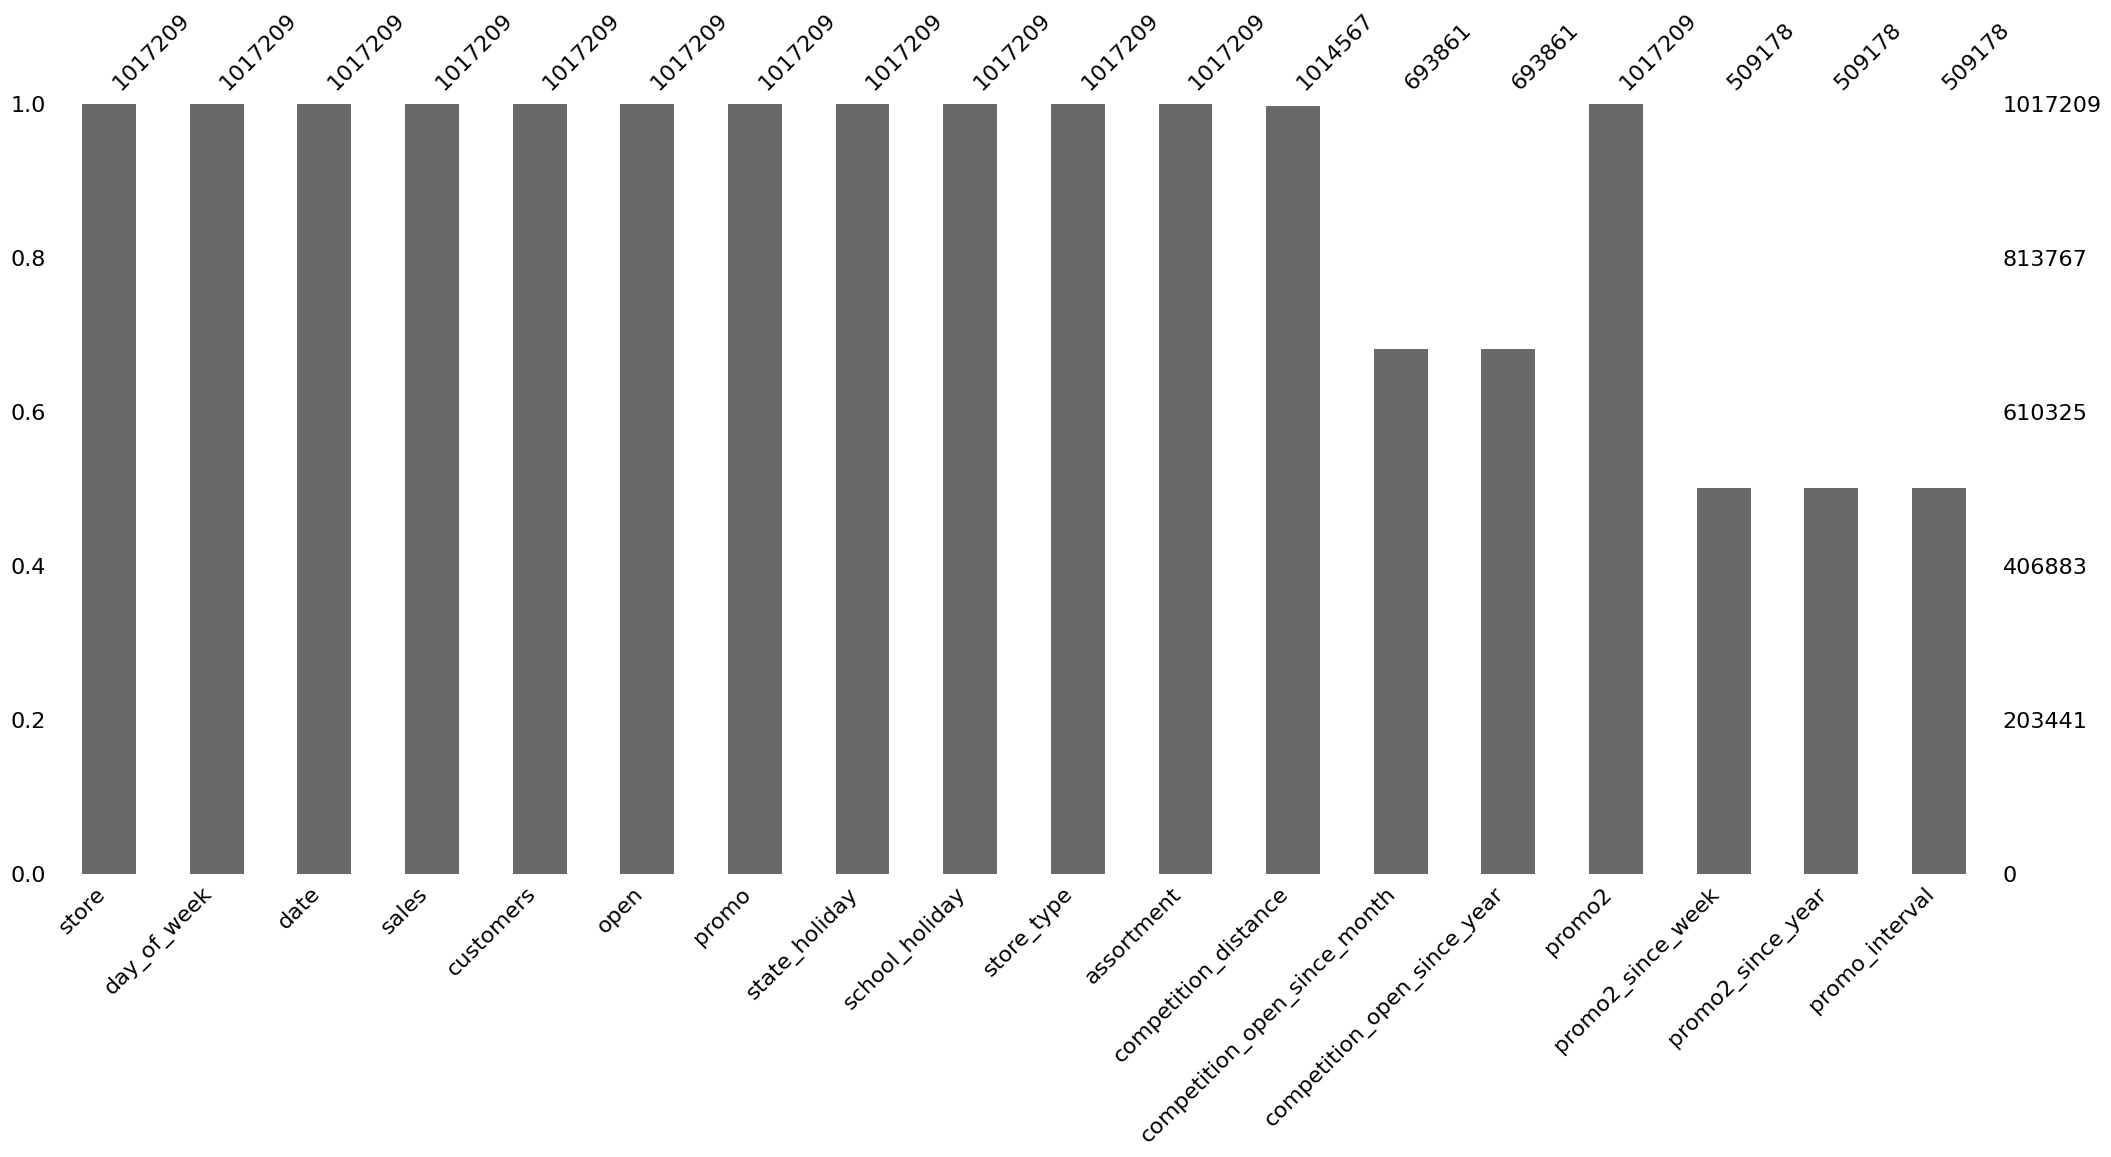

In [19]:
msno.bar(Merged_Trian_df)


<Axes: >

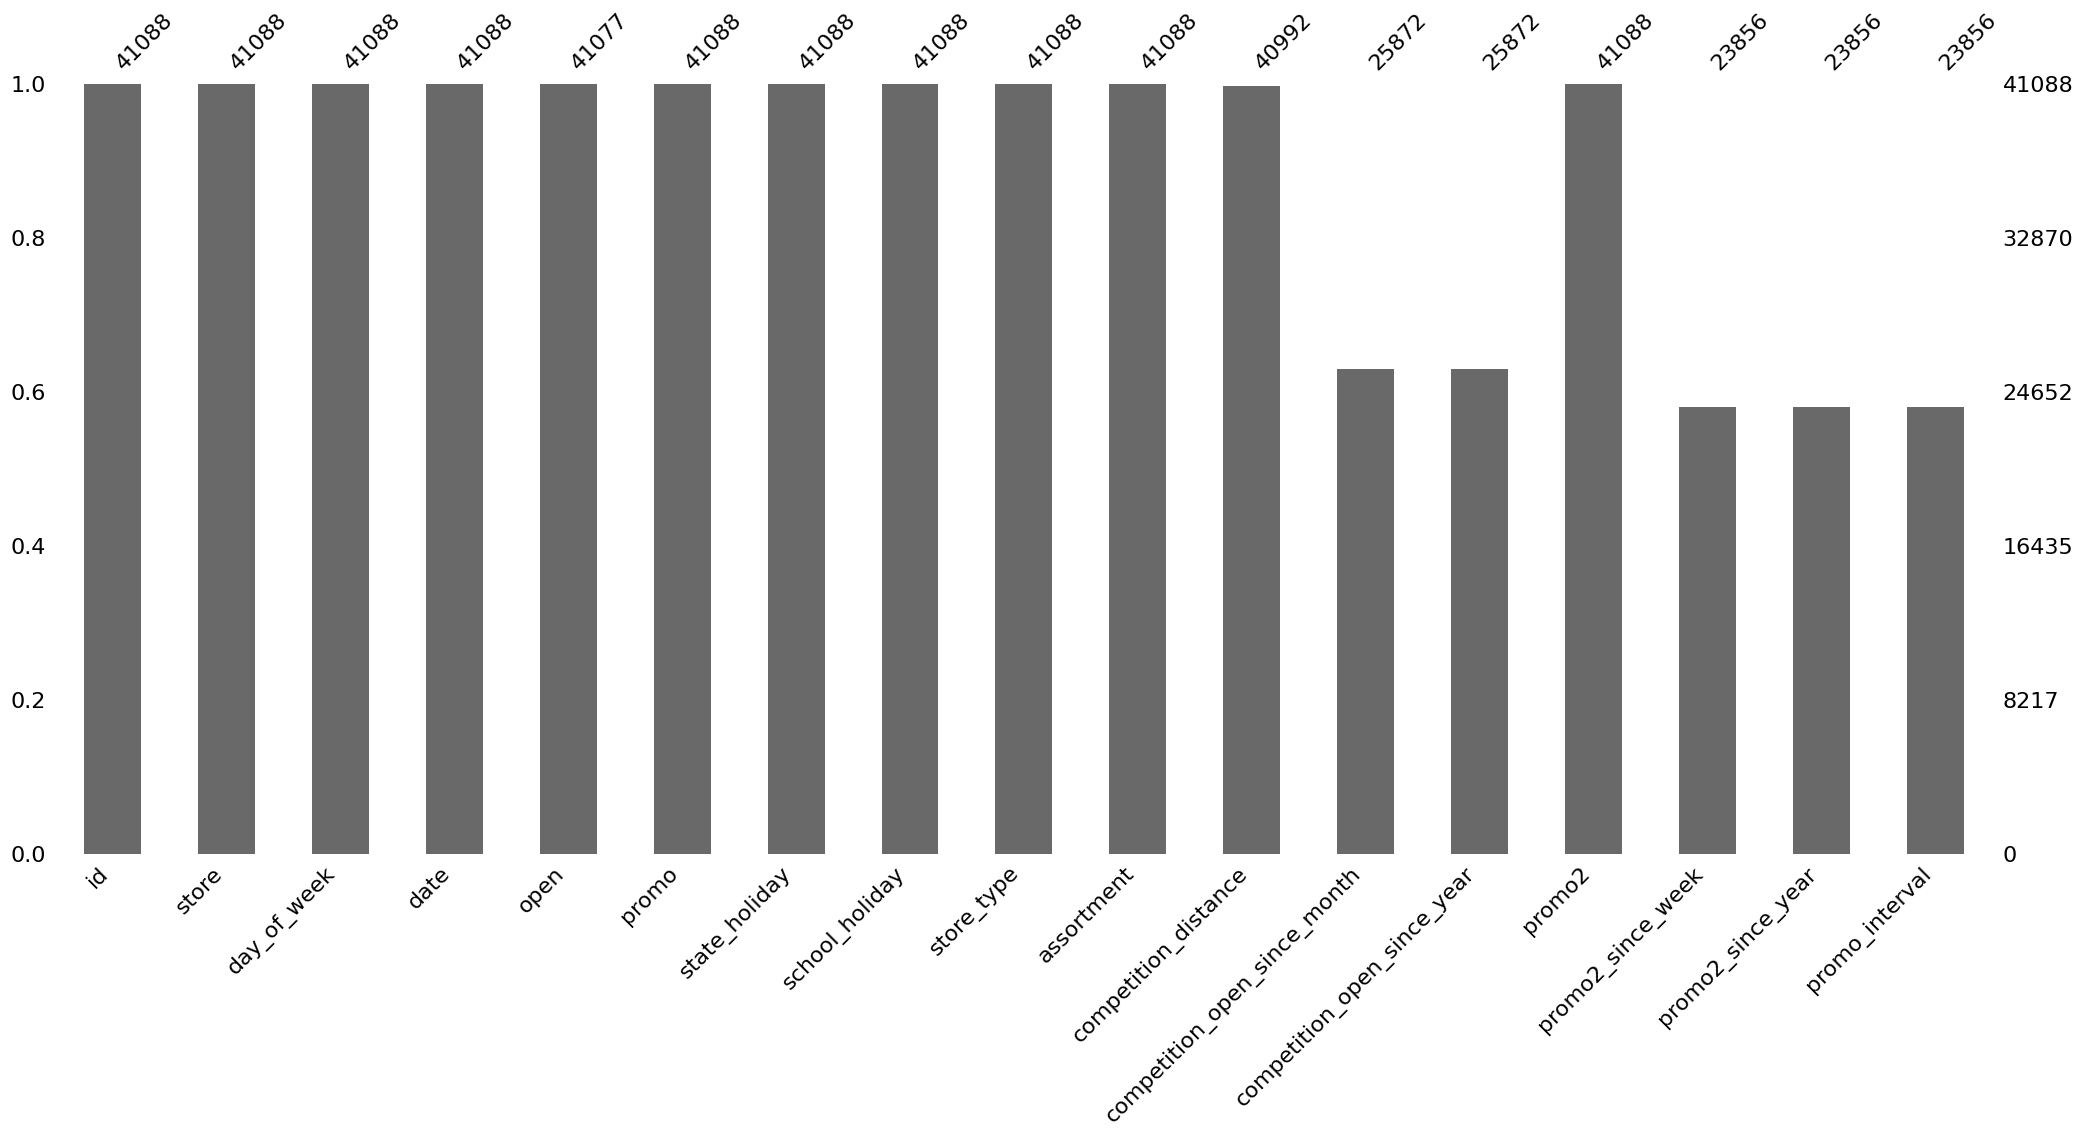

In [20]:
msno.bar(Merged_test_df)

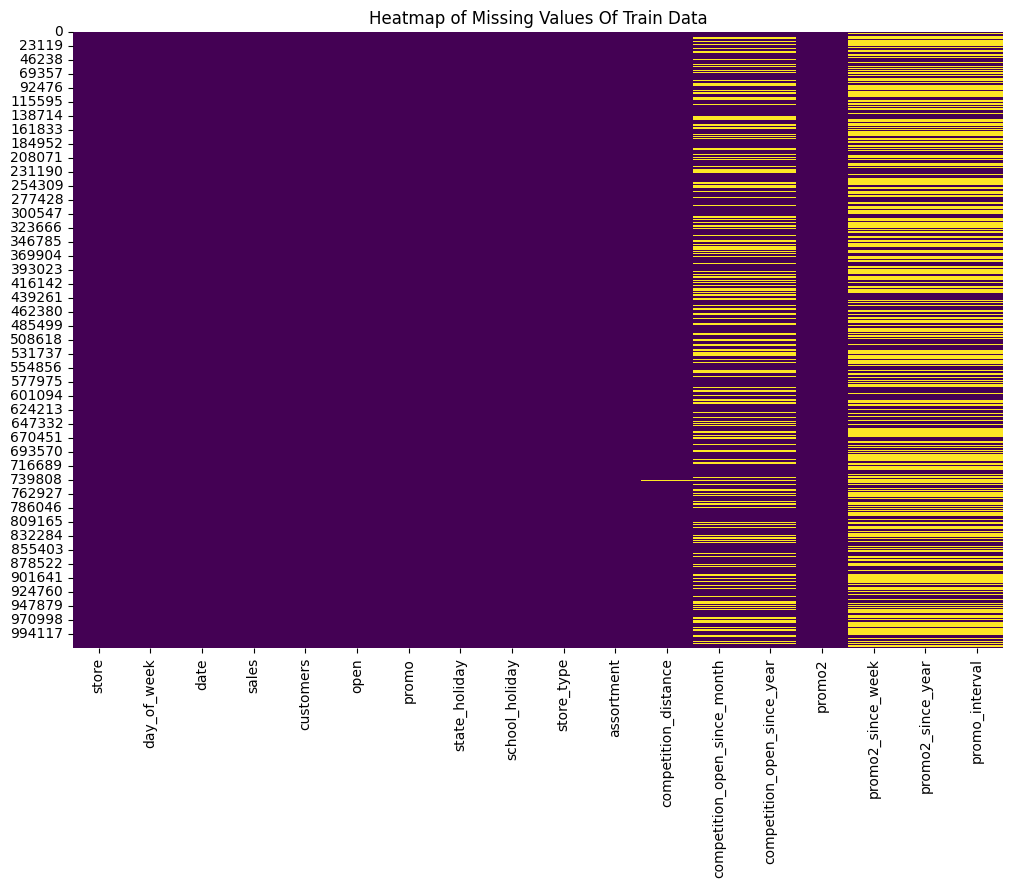

In [21]:
plt.figure(figsize=(12,8))
sns.heatmap(Merged_Trian_df.isnull(), cbar=False, cmap='viridis')
plt.title('Heatmap of Missing Values Of Train Data')
plt.show()

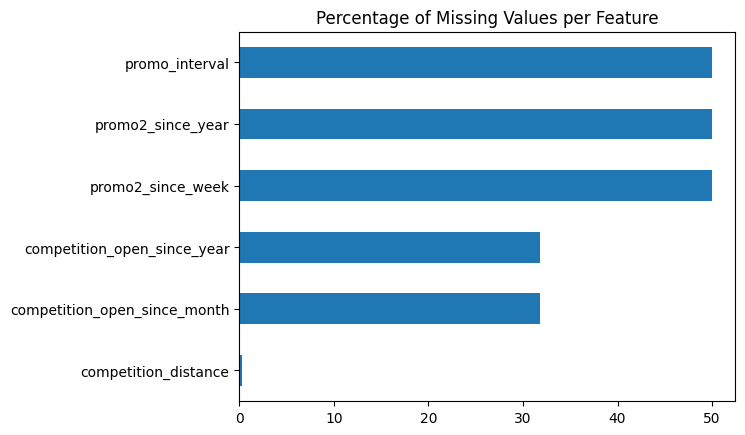

In [22]:
missing_percentage = Merged_Trian_df.isnull().mean() * 100
missing_percentage[missing_percentage > 0].sort_values().plot(kind='barh')
plt.title('Percentage of Missing Values per Feature')
plt.show()

# **Data Types**

In [23]:
Merged_Trian_df['date'] = pd.to_datetime(Merged_Trian_df['date'])
Merged_Trian_df.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

# **Check Na**

In [24]:
Merged_Trian_df.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

# **FIllout NA**

In [25]:
def clean_competition_and_promo_data(df):
    # Fill missing values for 'CompetitionDistance' by group median
    df['competition_distance'] = df.groupby(['store_type', 'assortment'])['competition_distance'].transform(lambda x: x.fillna(x.median()))

    # Interpolate missing values for 'CompetitionOpenSinceMonth' and 'CompetitionOpenSinceYear'
    df['competition_open_since_month'] = df['competition_open_since_month'].interpolate(method='linear', limit_direction='forward', axis=0)
    df['competition_open_since_year'] = df['competition_open_since_year'].interpolate(method='linear', limit_direction='forward', axis=0)

    # Fill missing values for 'Promo2SinceWeek' and 'Promo2SinceYear' with 0
    df['promo2_since_week'] = df['promo2_since_week'].fillna(0)
    df['promo2_since_year'] = df['promo2_since_year'].fillna(0)

    # Fill missing values for 'PromoInterval' with "Missing"
    df['promo_interval'] = df['promo_interval'].fillna("Missing")

    return df


<Axes: >

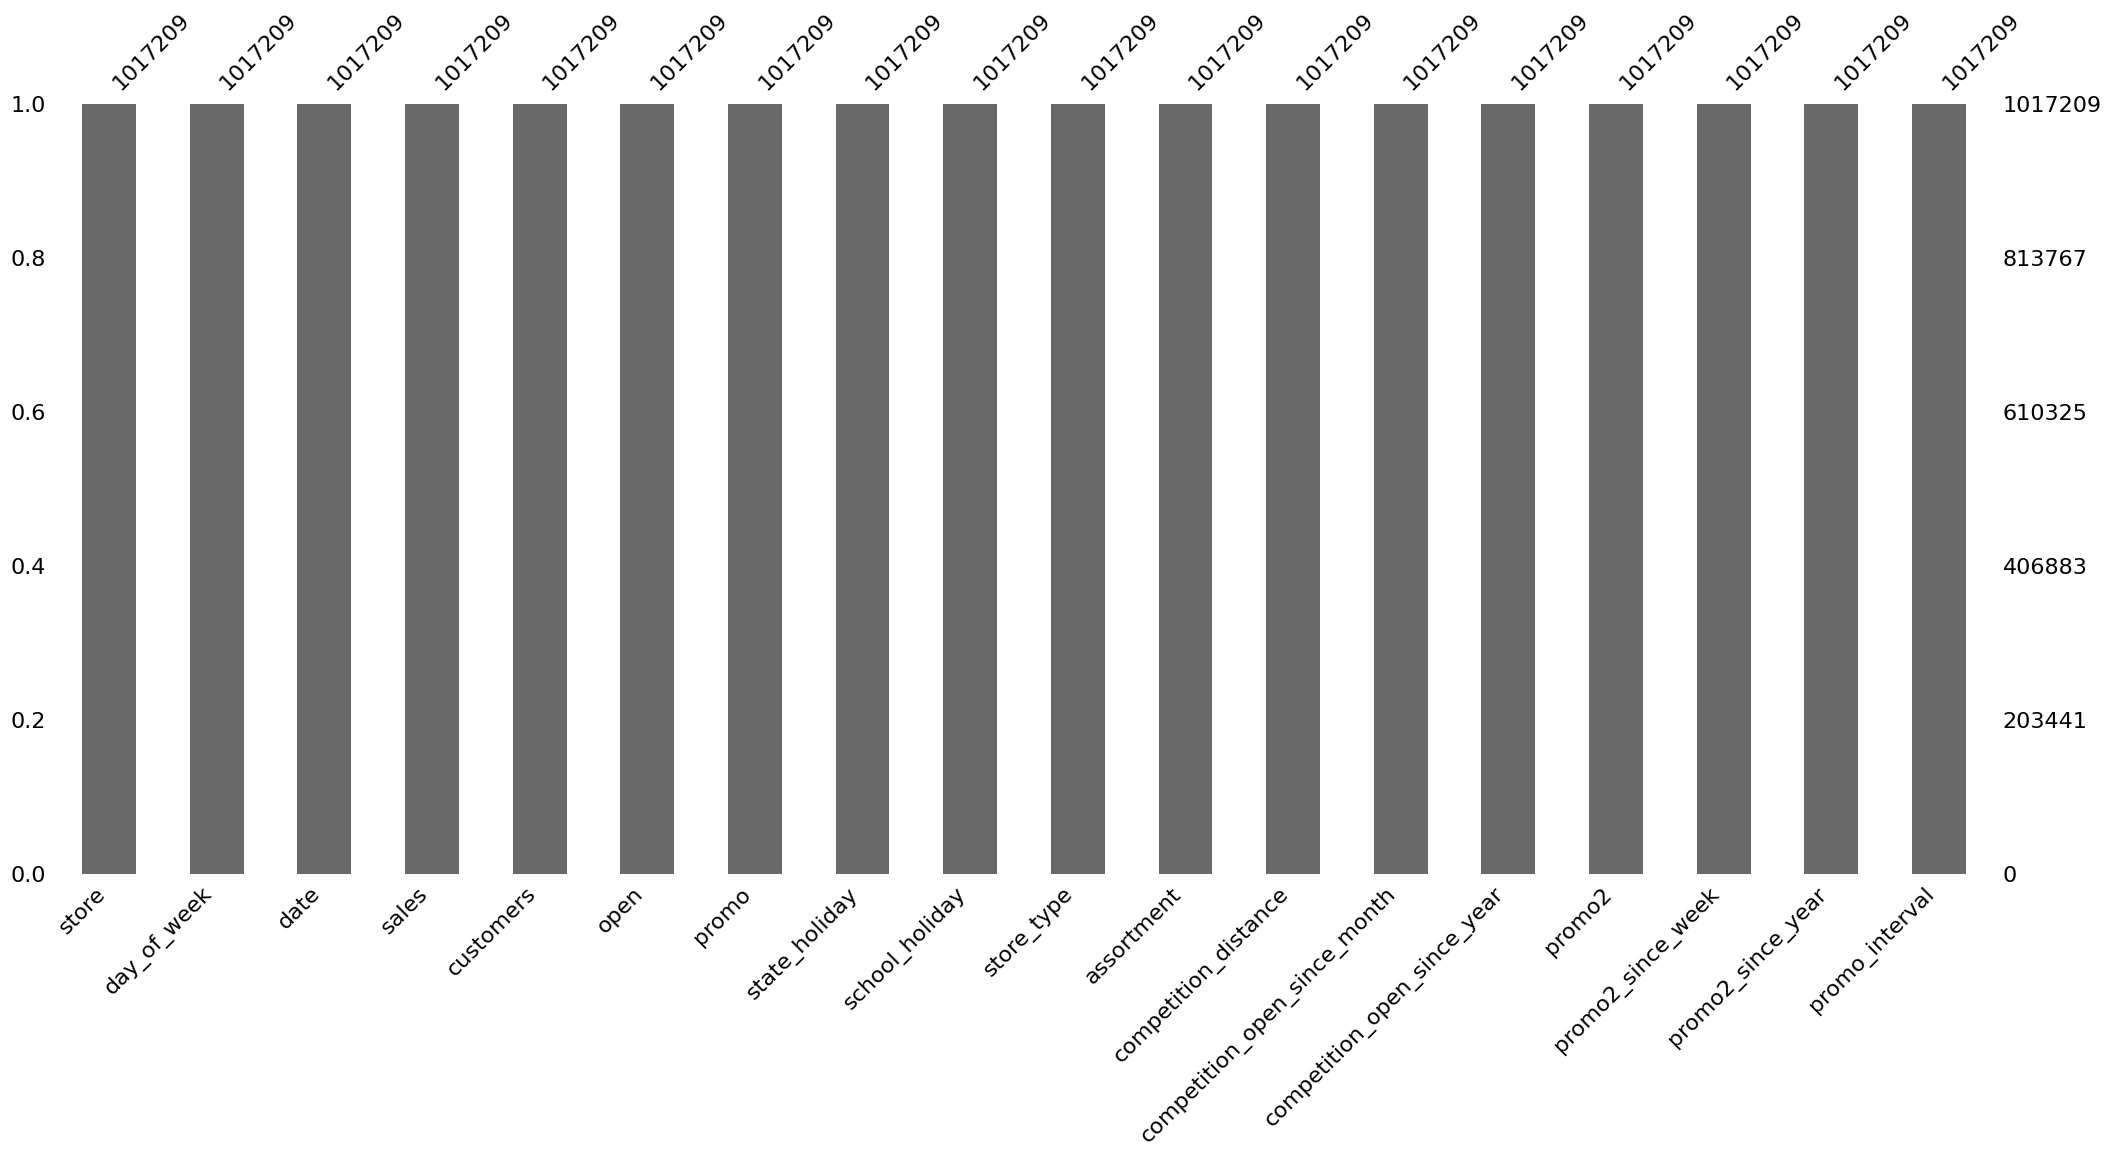

In [26]:
clean_competition_and_promo_data(Merged_Trian_df)
msno.bar(Merged_Trian_df)

<Axes: >

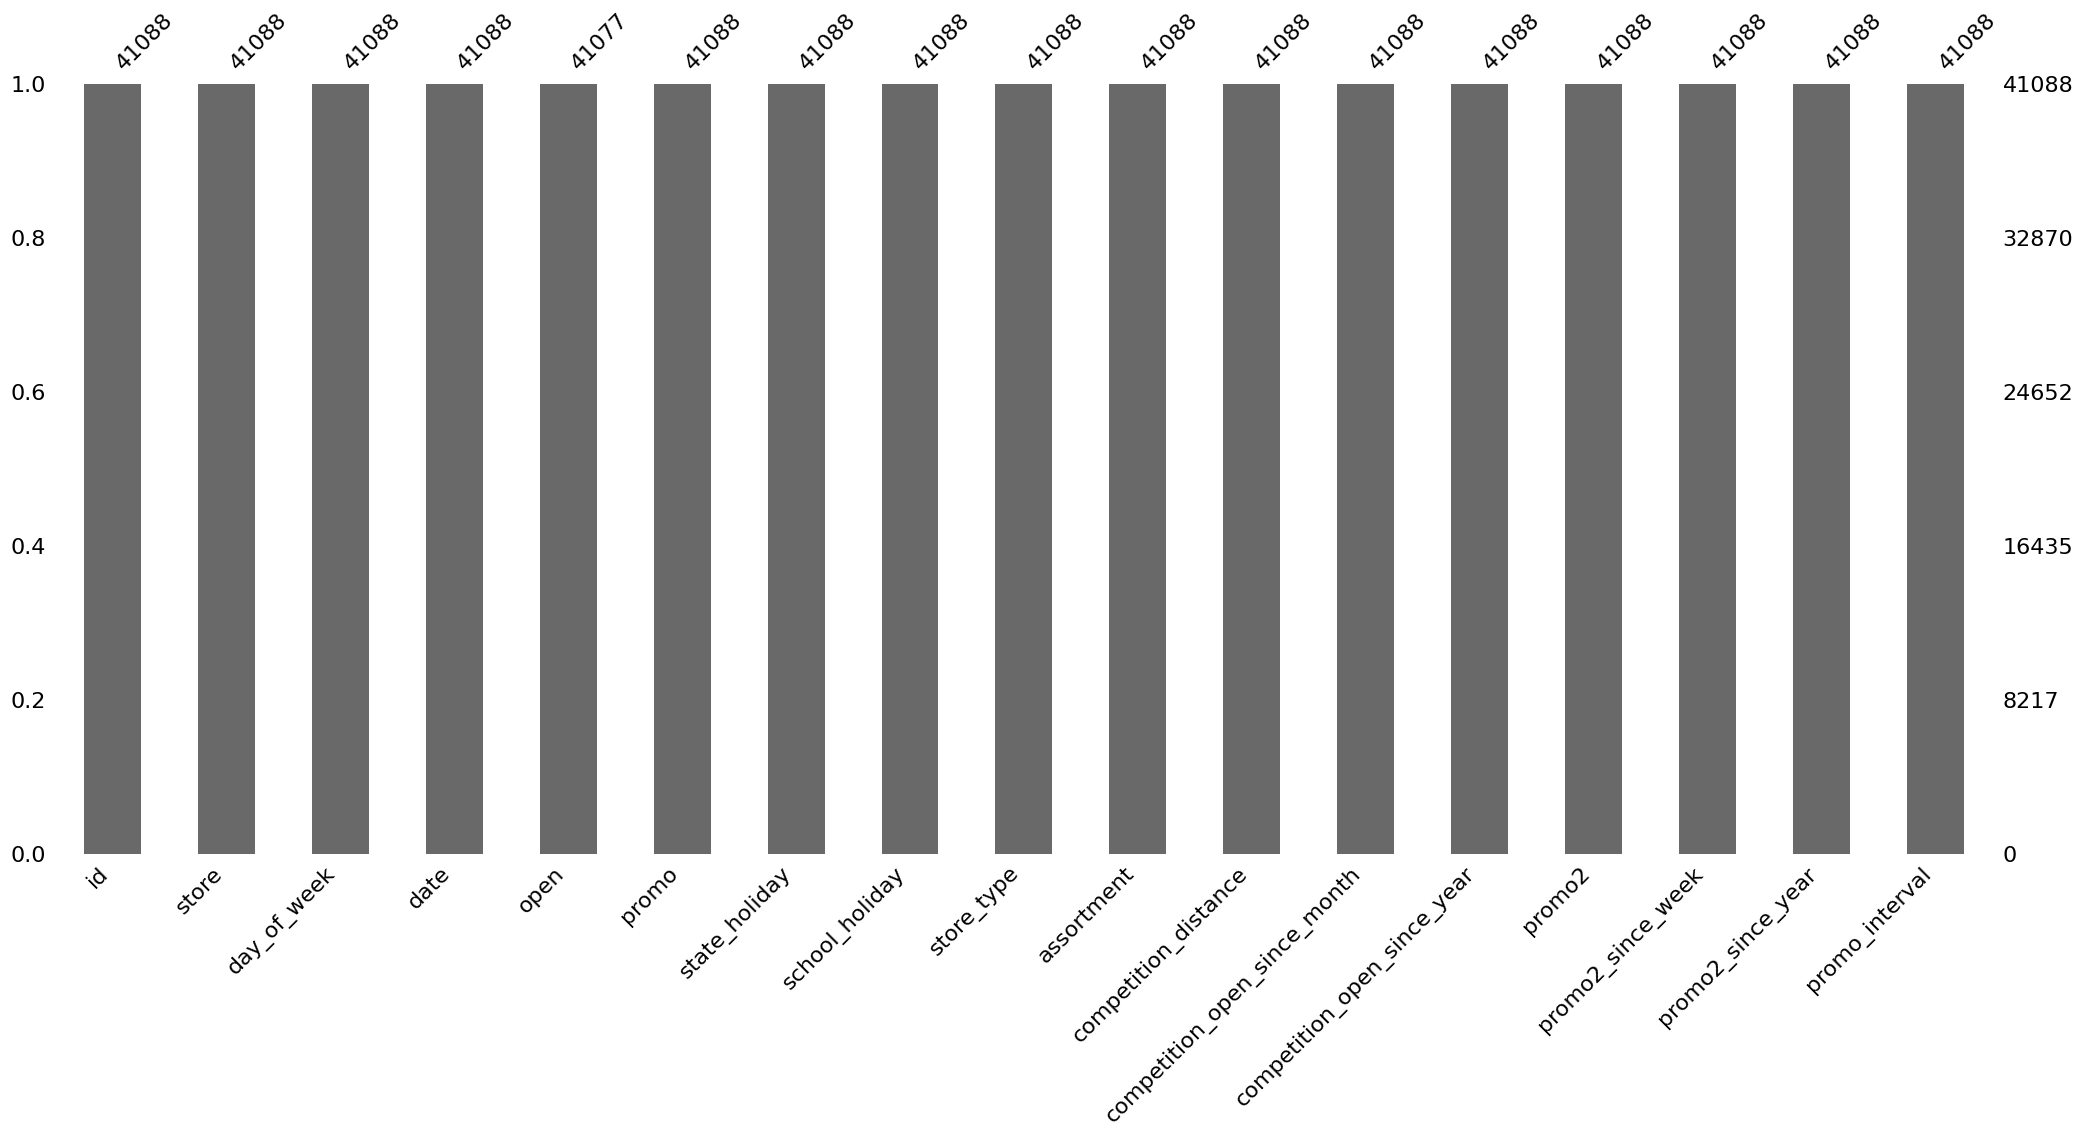

In [27]:
clean_competition_and_promo_data(Merged_test_df)
msno.bar(Merged_test_df)

# ** Deep EDA **

> Add blockquote



In [28]:
# Changes data Types :
Merged_Trian_df['competition_open_since_month'] = Merged_Trian_df['competition_open_since_month'].astype(int)
Merged_Trian_df['competition_open_since_year'] = Merged_Trian_df['competition_open_since_year'].astype(int)

Merged_Trian_df['promo2_since_week'] = Merged_Trian_df['promo2_since_week'].astype(int)
Merged_Trian_df['promo2_since_year'] = Merged_Trian_df['promo2_since_year'].astype(int)

In [29]:
#  Describtive Statistics
# select numercial columns
num_attributes = Merged_Trian_df.select_dtypes(include=['int64', 'float64', ])

# select categorical columns
cat_attributes = Merged_Trian_df.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

In [30]:
# Central Tendency and Dispersion Metrics
metrics = num_attributes.agg(['min', 'max', lambda x: x.max() - x.min(), 'mean', 'median', 'std', 'skew', 'kurtosis']).T

# Rename columns
metrics.columns = ['min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

# Reset index
metrics = metrics.reset_index().rename(columns={'index': 'attributes'})


In [31]:
metrics

attributes     min      max    range         mean  \
0                          store     1.0   1115.0   1114.0   558.429727   
1                    day_of_week     1.0      7.0      6.0     3.998341   
2                          sales     0.0  41551.0  41551.0  5773.818972   
3                      customers     0.0   7388.0   7388.0   633.145946   
4                           open     0.0      1.0      1.0     0.830107   
5                          promo     0.0      1.0      1.0     0.381515   
6                 school_holiday     0.0      1.0      1.0     0.178647   
7           competition_distance    20.0  75860.0  75840.0  5425.493257   
8   competition_open_since_month     1.0     12.0     11.0     7.081165   
9    competition_open_since_year  1900.0   2015.0    115.0  2008.591373   
10                        promo2     0.0      1.0      1.0     0.500564   
11             promo2_since_week     0.0     50.0     50.0    11.647665   
12             promo2_since_year     0.0   2015.0   2015.0  1007.010608   

    median          std      skew    kurtosis  
0    558.0   321.908651 -0.000955   -1.200524  
1      4.0     1.997391  0.001593   -1.246873  
2   5744.0  3849.926175  0.641460    1.778375  
3    609.0   464.411734  1.598650    7.091773  
4      1.0     0.375539 -1.758045    1.090723  
5      0.0     0.485759  0.487838   -1.762018  
6      0.0     0.383056  1.677842    0.815154  
7   2330.0  7705.988854  2.933279   13.042948  
8      7.0     2.950362 -0.103887   -1.079385  
9   2009.0     5.642644 -7.154013  113.652099  
10     1.0     0.500000 -0.002255   -1.999999  
11     1.0    15.323928  1.003390   -0.498322  
12  2009.0  1005.876930 -0.002251   -1.999993

from matplotlib import pyplot as plt
metrics['min'].plot(kind='hist', bins=20, title='min')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
metrics['max'].plot(kind='hist', bins=20, title='max')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
metrics['range'].plot(kind='hist', bins=20, title='range')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
metrics['mean'].plot(kind='hist', bins=20, title='mean')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
metrics.plot(kind='scatter', x='min', y='max', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
metrics.plot(kind='scatter', x='max', y='range', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
metrics.plot(kind='scatter', x='range', y='mean', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
metrics.plot(kind='scatter', x='mean', y='median', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
metrics['min'].plot(kind='line', figsize=(8, 4), title='min')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
metrics['max'].plot(kind='line', figsize=(8, 4), title='max')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
metrics['range'].plot(kind='line', figsize=(8, 4), title='range')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
metrics['mean'].plot(kind='line', figsize=(8, 4), title='mean')
plt.gca().spines[['top', 'right']].set_visible(False)

# **Categorical Attributes**

In [32]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

state_holiday     4
store_type        4
assortment        3
promo_interval    4
dtype: int64

# **Visualization**

# * univable analysis  

<Axes: xlabel='sales', ylabel='Count'>

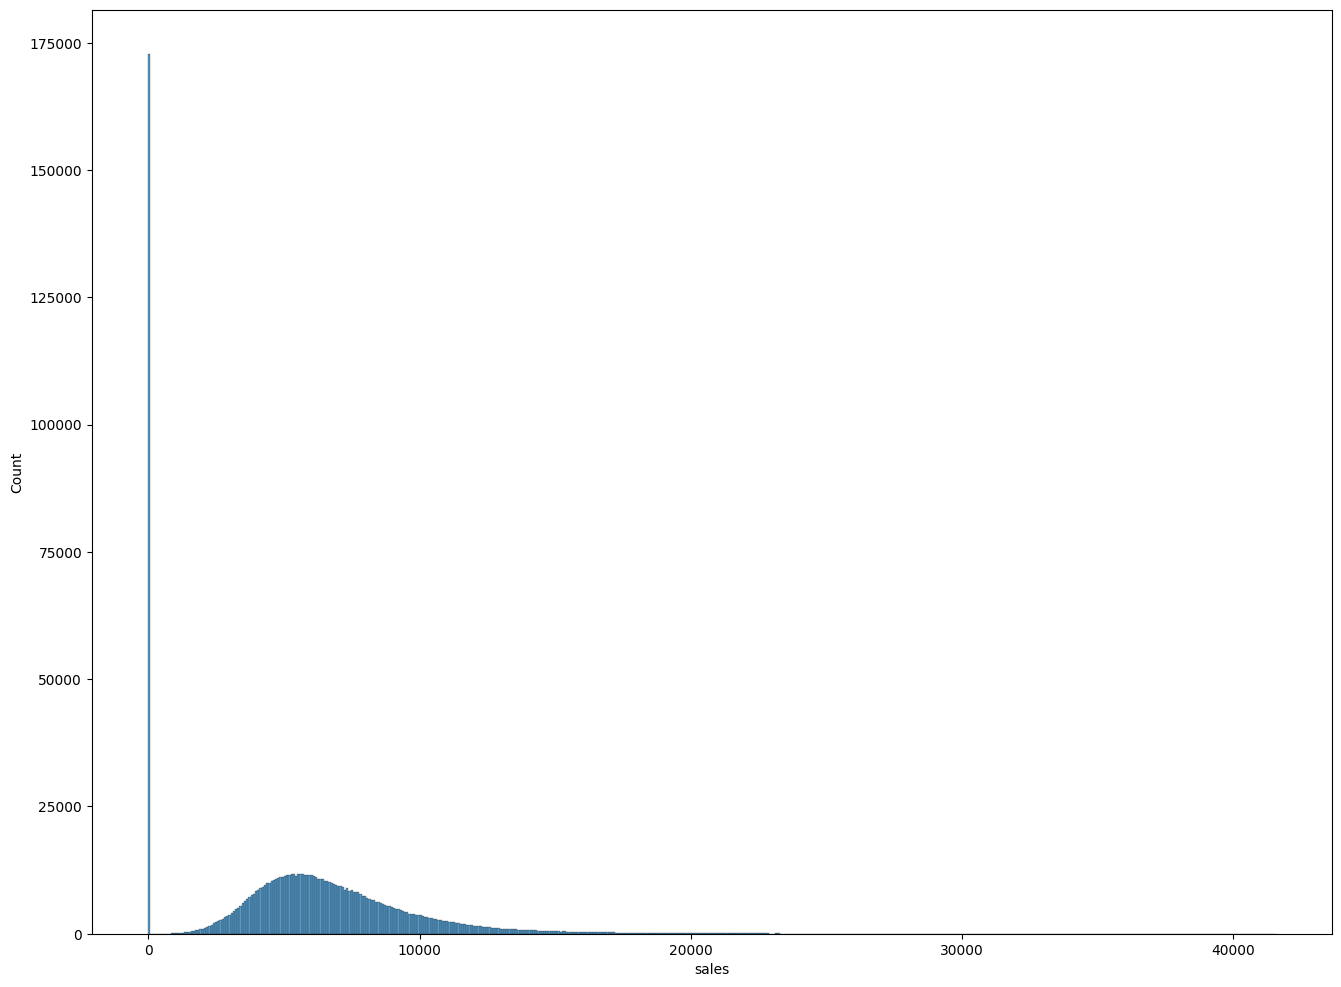

In [33]:
plt.rcParams['figure.figsize'] = [16, 12]
sns.histplot( Merged_Trian_df['sales'] )

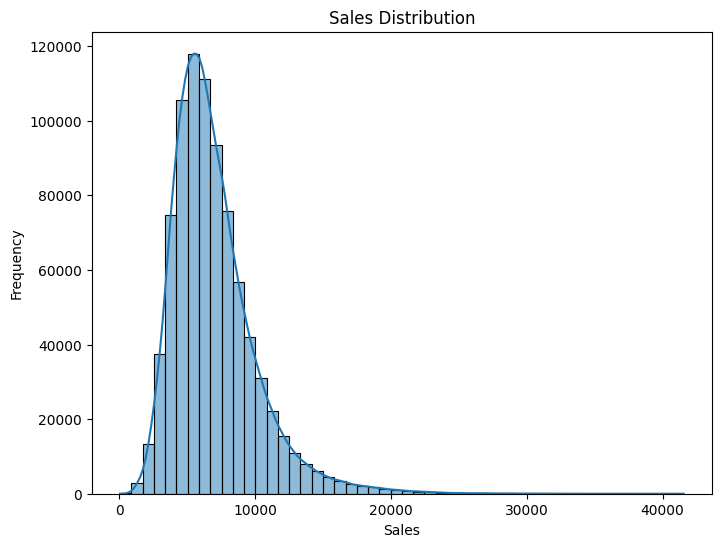

In [34]:
# Filter the DataFrame
df = Merged_Trian_df[(Merged_Trian_df['open'] != 0) & (Merged_Trian_df['sales'] > 0)]

# Drop unnecessary columns
cols_drop = ['customers', 'open', 'promo_interval']
df2 = df.drop(cols_drop, axis=1)

# Create the histogram with Seaborn
plt.figure(figsize=(8, 6))  # Matches the original figure size
sns.histplot(df2['sales'], bins=50, kde=True)

# Add title and labels
plt.title('Sales Distribution')
plt.xlabel('Sales')
plt.ylabel('Frequency')

# Show the plot
plt.show()

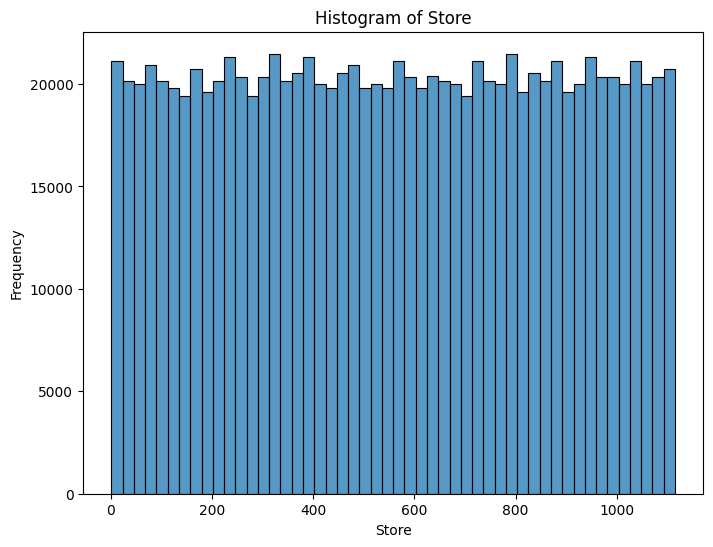

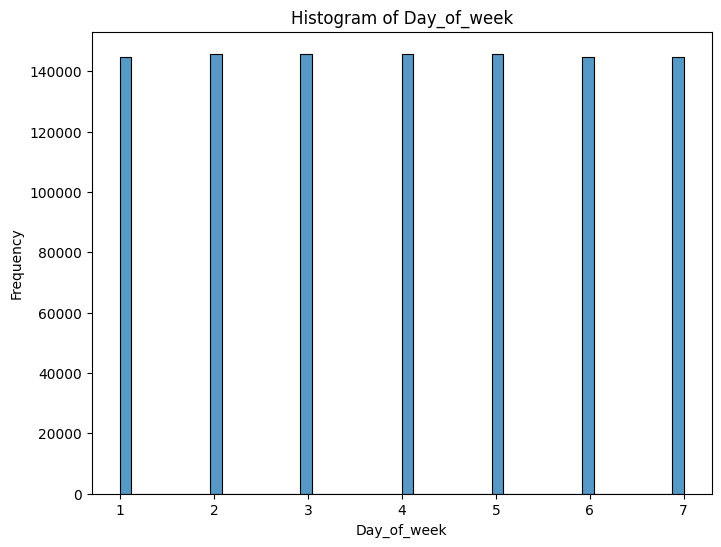

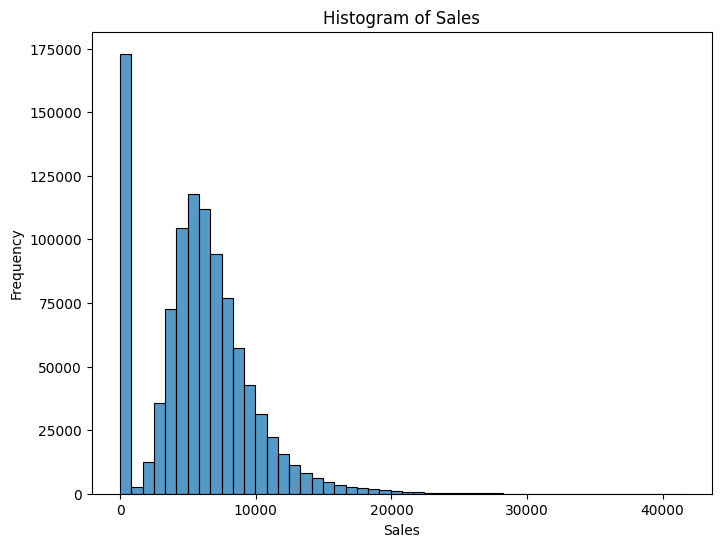

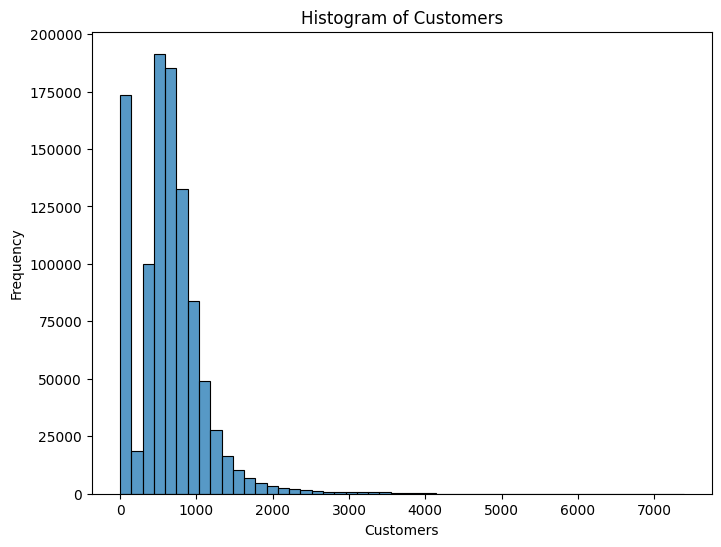

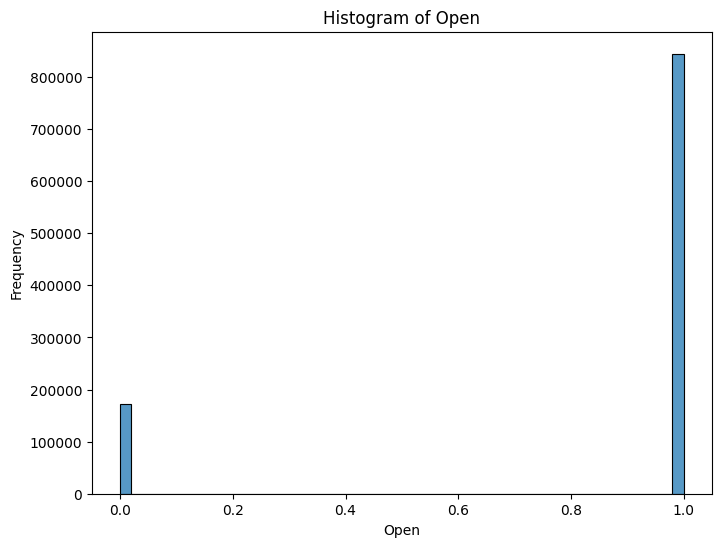

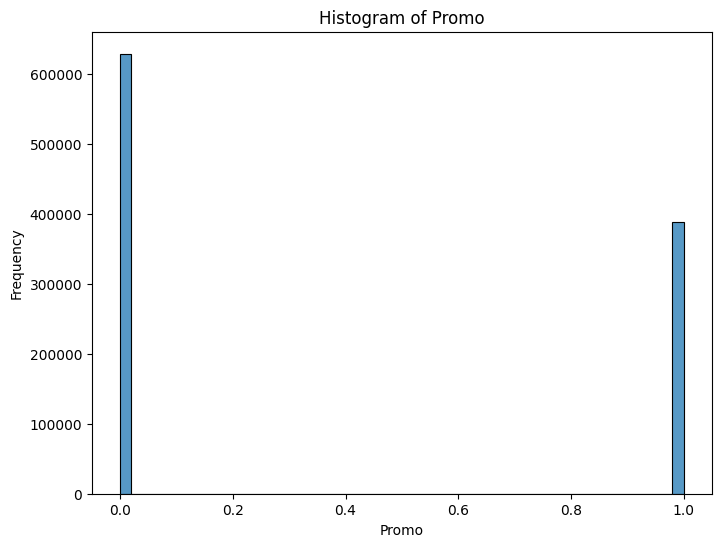

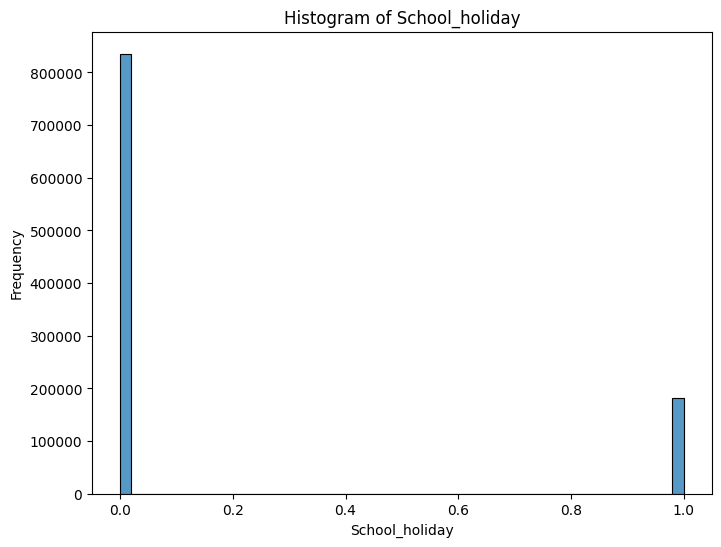

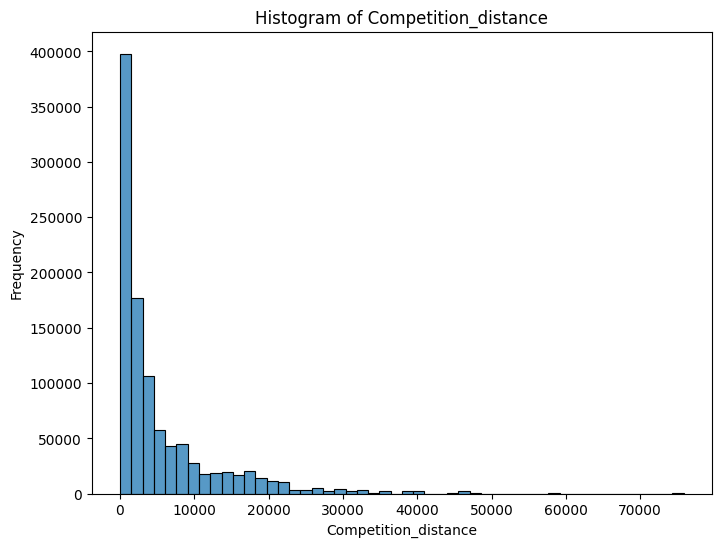

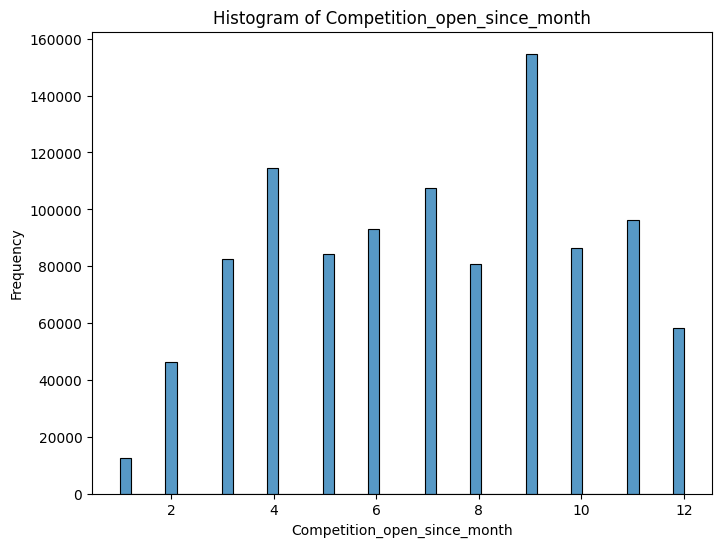

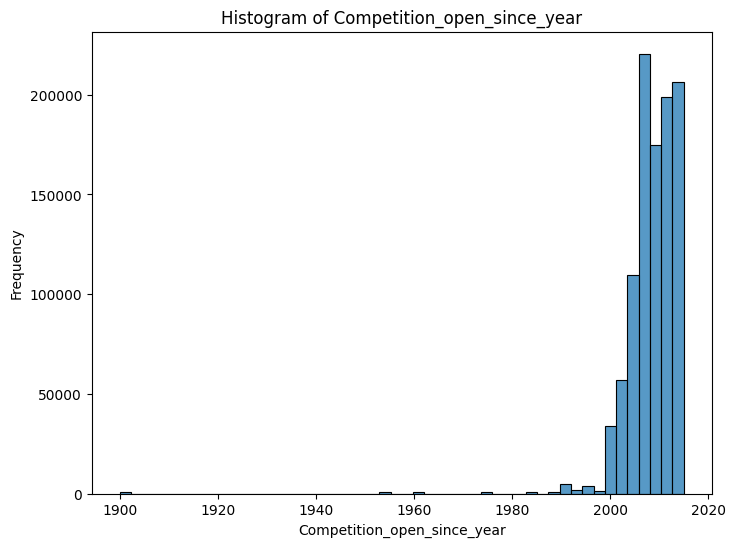

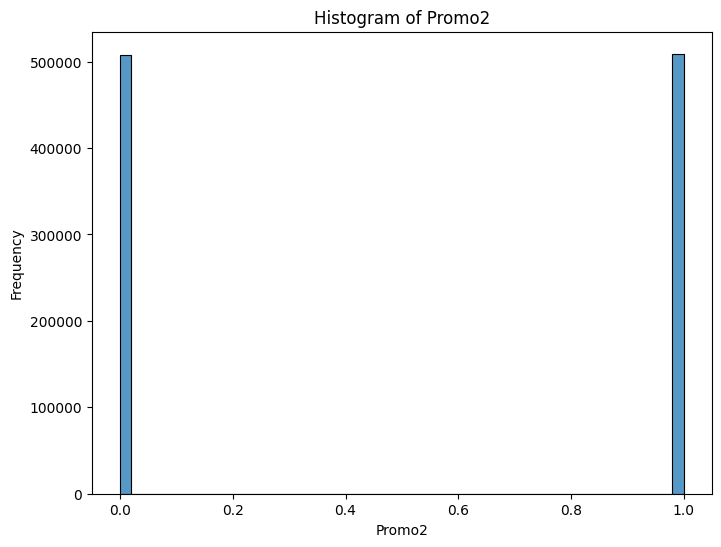

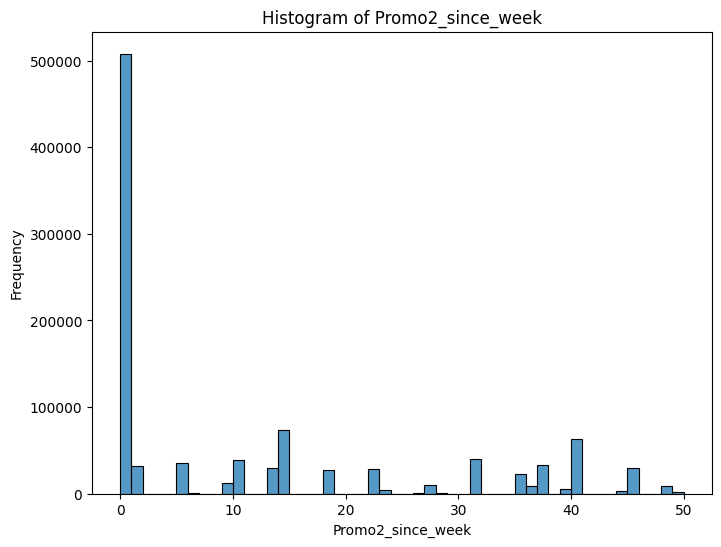

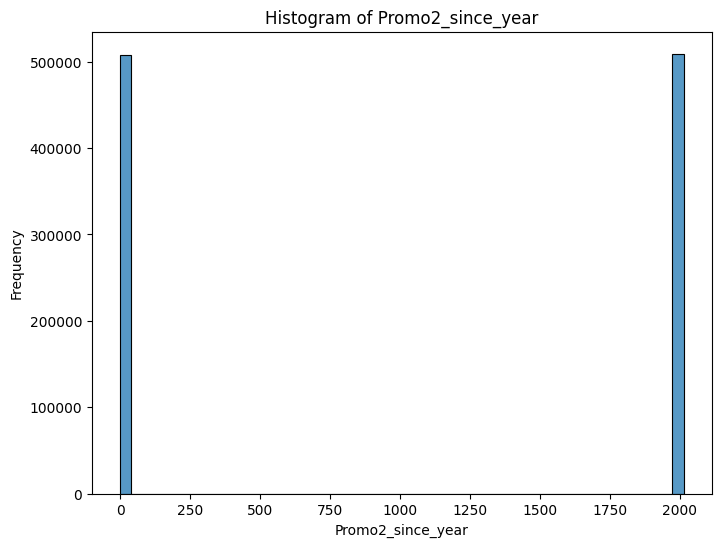

In [35]:
# List of numerical columns distribution
num_columns = ['store', 'day_of_week', 'sales', 'customers', 'open', 'promo',
               'school_holiday', 'competition_distance', 'competition_open_since_month',
               'competition_open_since_year', 'promo2', 'promo2_since_week', 'promo2_since_year']

# Generate individual histograms for each column
for column in num_columns:
    plt.figure(figsize=(8, 6))
    sns.histplot(Merged_Trian_df[column], bins=50, kde=False)
    plt.title(f'Histogram of {column.capitalize()}')
    plt.xlabel(column.capitalize())
    plt.ylabel('Frequency')
    plt.show()

<Figure size 1000x600 with 0 Axes>

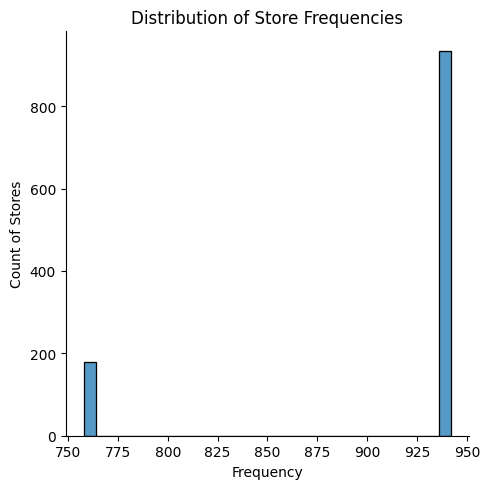

In [36]:
# 1. Categorical Variables
# Store
# Prepare data: Get the store frequency count
store_counts = Merged_Trian_df['store'].value_counts().reset_index()
store_counts.columns = ['store', 'count']

# Create the distribution plot (displot) using Seaborn
plt.figure(figsize=(10, 6))
sns.displot(store_counts['count'], bins=30, kde=False)

# Add title and labels
plt.title('Distribution of Store Frequencies')
plt.xlabel('Frequency')
plt.ylabel('Count of Stores')

# Show the plot
plt.tight_layout()
plt.show()


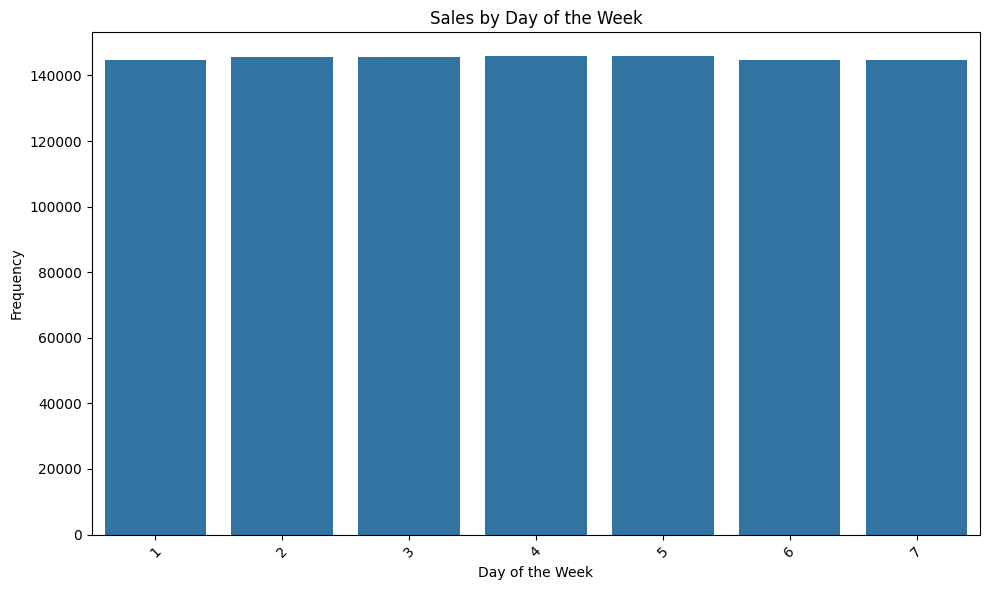

In [37]:
# DayOfWeek
# Prepare data: Get the day of the week frequency count
day_of_week_counts = Merged_Trian_df['day_of_week'].value_counts().reset_index()
day_of_week_counts.columns = ['day_of_week', 'count']

# Create the bar plot using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='day_of_week', y='count', data=day_of_week_counts)

# Add title and labels
plt.title('Sales by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Frequency')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

# Bivariate

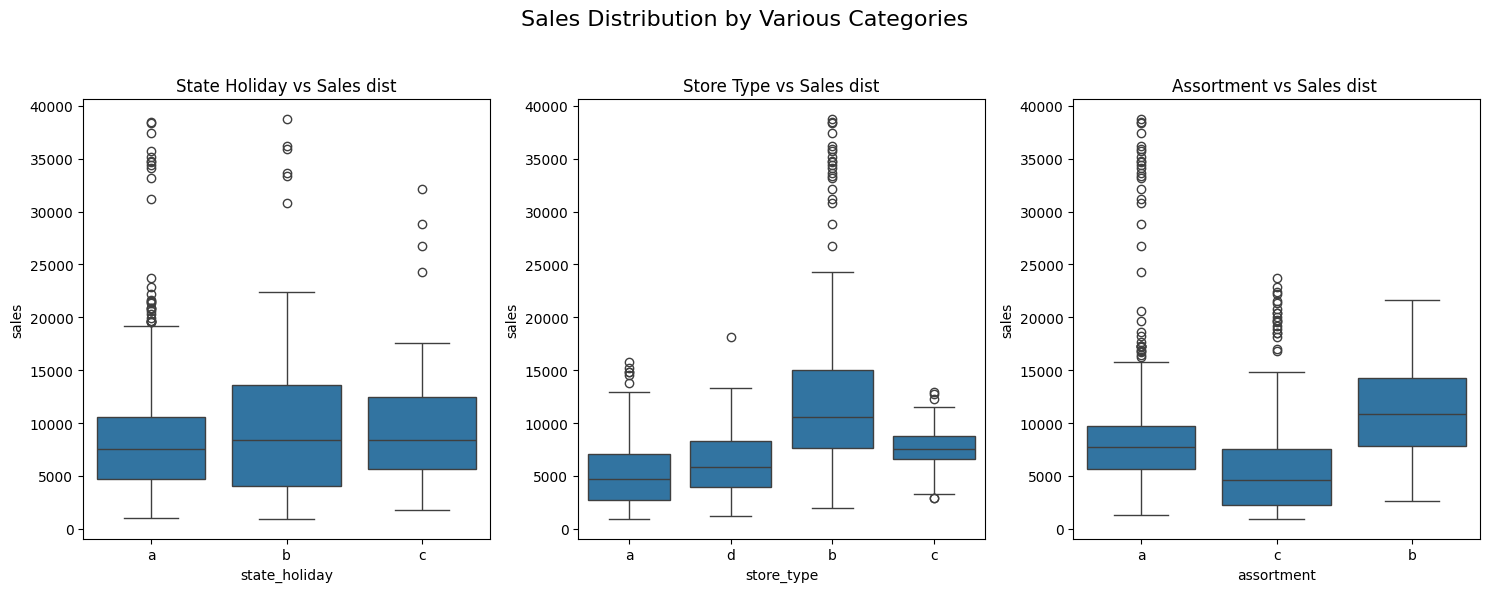

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter the data
aux1 = Merged_Trian_df[(Merged_Trian_df['state_holiday'] != '0') & (Merged_Trian_df['sales'] > 0)]

# Set up the figure and axes for 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 6))
fig.suptitle("Sales Distribution by Various Categories", fontsize=16)

# First subplot: State Holiday vs Sales
sns.boxplot(x='state_holiday', y='sales', data=aux1, ax=axes[0])
axes[0].set_title('State Holiday vs Sales dist')

# Second subplot: Store Type vs Sales
sns.boxplot(x='store_type', y='sales', data=aux1, ax=axes[1])
axes[1].set_title('Store Type vs Sales dist')

# Third subplot: Assortment vs Sales
sns.boxplot(x='assortment', y='sales', data=aux1, ax=axes[2])
axes[2].set_title('Assortment vs Sales dist ')

# Adjust layout for better appearance
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


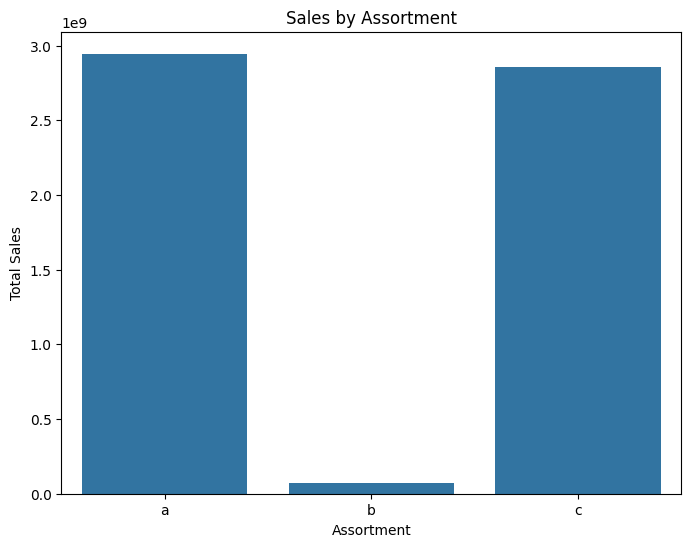

In [39]:
# Group by 'assortment' and sum 'sales'
aux1 = Merged_Trian_df[['assortment', 'sales']].groupby('assortment').sum().reset_index()

# Create bar plot with Seaborn
plt.figure(figsize=(8, 6))
sns.barplot(x='assortment', y='sales', data=aux1)

# Add title and labels
plt.title("Sales by Assortment")
plt.xlabel("Assortment")
plt.ylabel("Total Sales")

# Show the plot
plt.show()


<Axes: >

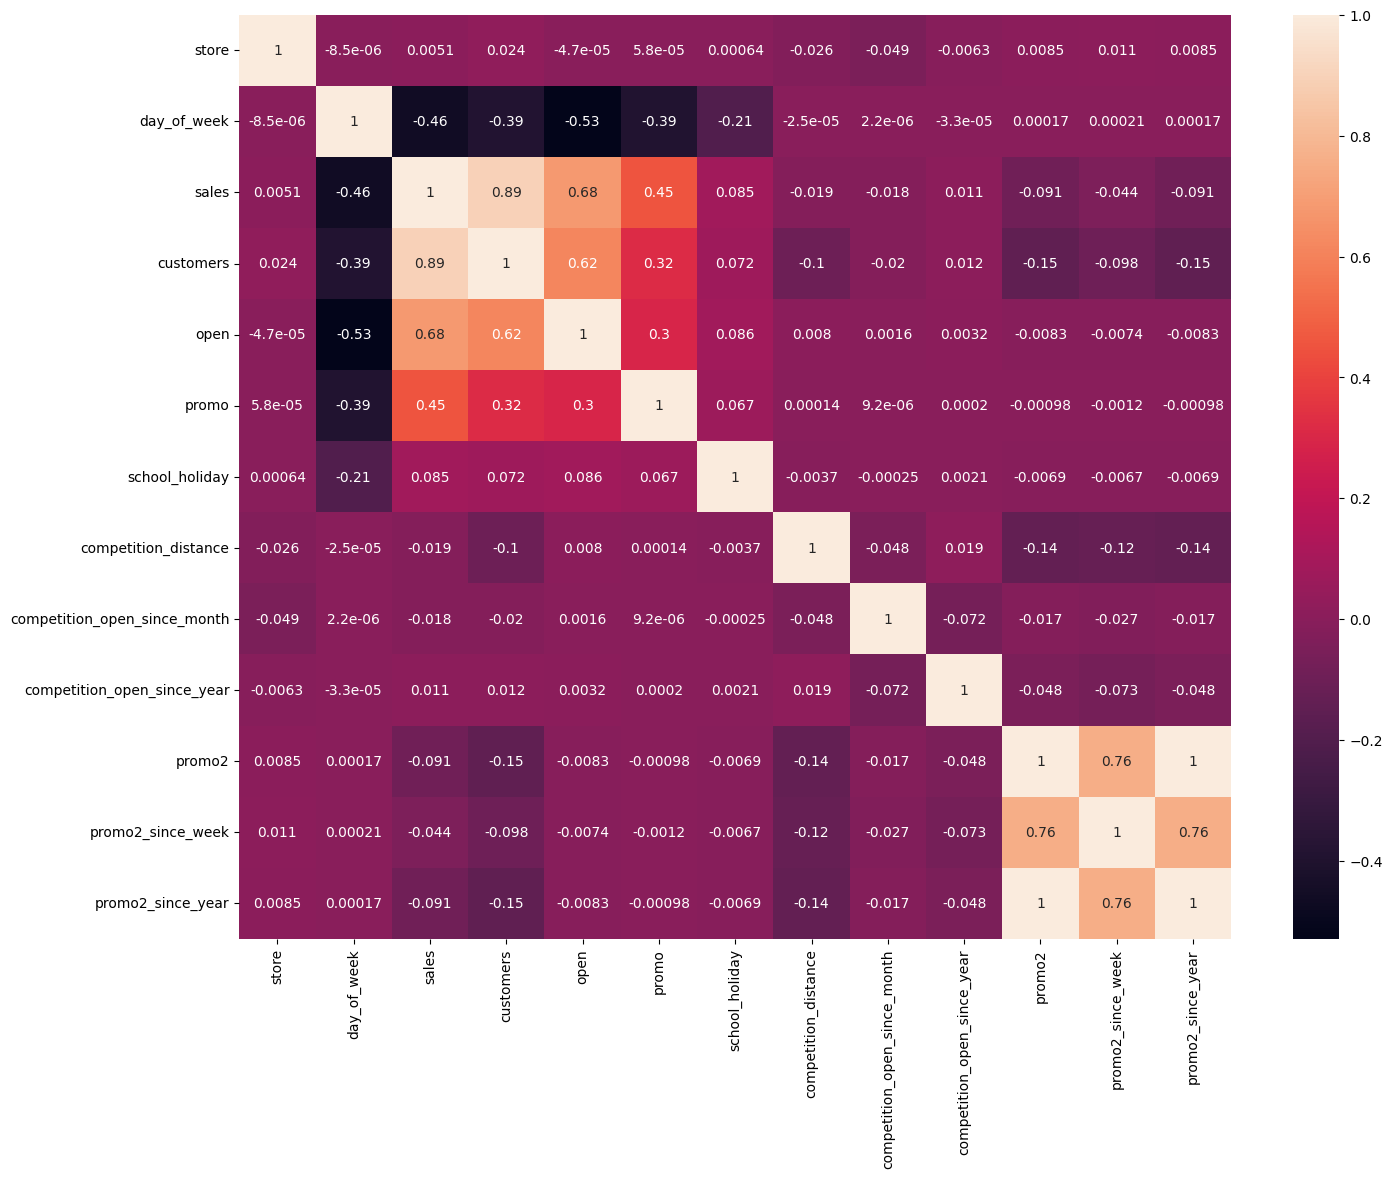

In [40]:
correlation = num_attributes.corr( method='pearson' )
sns.heatmap( correlation, annot=True )

In [41]:
aux1 = Merged_Trian_df[[
    'date',
    'sales',
    'promo',
    'state_holiday',
    'school_holiday'
]].groupby( 'date' ).agg( {'sales':'sum'} ).reset_index()

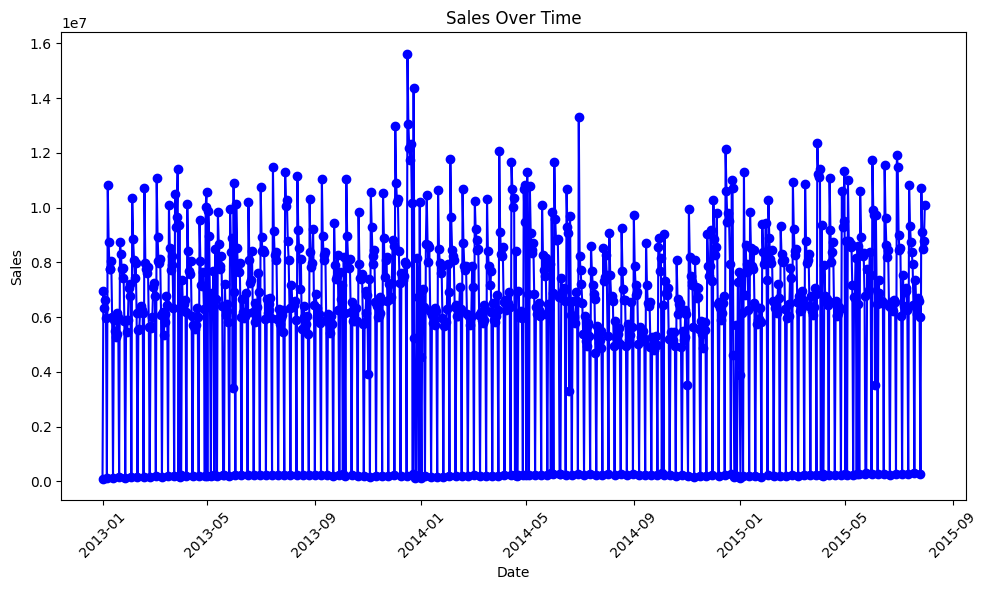

In [42]:
# Create line plot with Matplotlib
plt.figure(figsize=(10, 6))
plt.plot(aux1['date'], aux1['sales'], marker='o', linestyle='-', color='b')

# Add title and labels
plt.title('Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

In [43]:
aux1 = Merged_Trian_df[[
    'date',
    'sales',
    'customers'
]].groupby( 'date' ).agg( {'sales': 'sum', 'customers': 'sum'} ).reset_index()

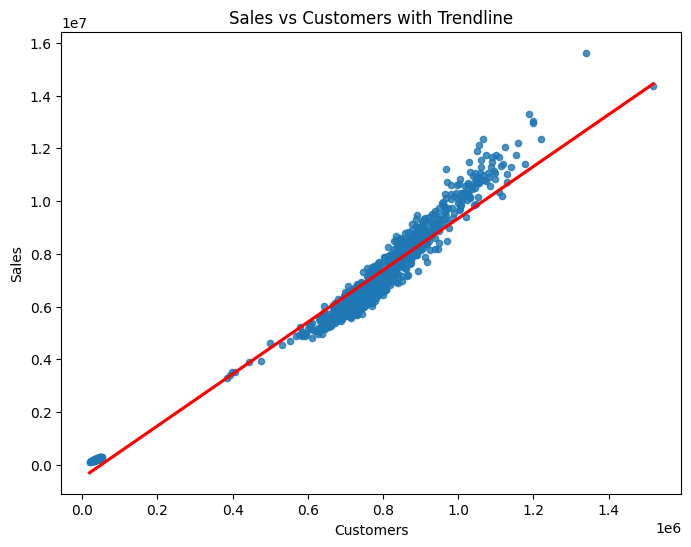

In [44]:
# Create scatter plot with Seaborn, adding a regression line
plt.figure(figsize=(8, 6))
sns.regplot(x='customers', y='sales', data=aux1, scatter_kws={'s': 20}, line_kws={'color': 'red'}, ci=None)

# Add title and labels
plt.title('Sales vs Customers with Trendline')
plt.xlabel('Customers')
plt.ylabel('Sales')

# Show the plot
plt.show()

In [45]:
df3 = Merged_Trian_df[['competition_distance', 'sales']].copy()

In [46]:
Merged_Trian_df.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

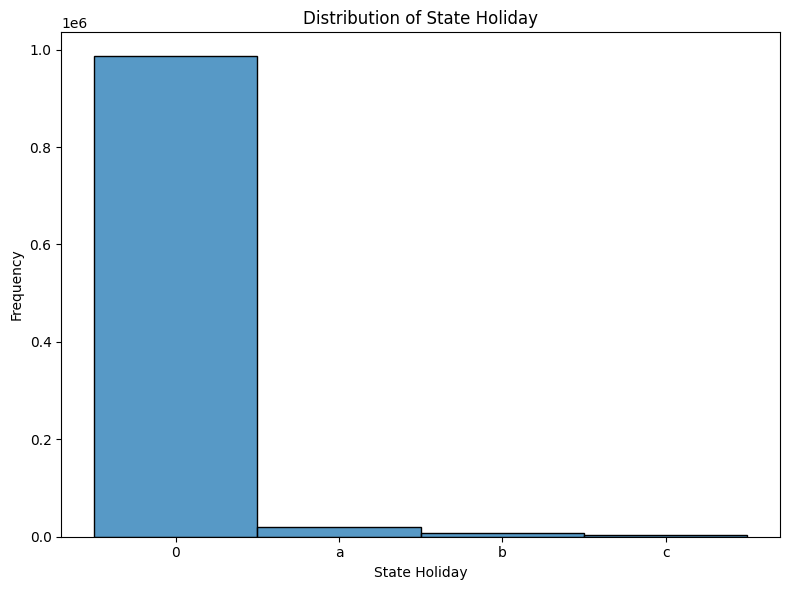

In [47]:
# StateHoliday
# Ensure state_holiday values are treated as strings
Merged_Trian_df['state_holiday'] = Merged_Trian_df['state_holiday'].astype(str)

# Create the histogram using Seaborn
plt.figure(figsize=(8, 6))
sns.histplot(Merged_Trian_df['state_holiday'], bins=10, discrete=True)  # Set discrete=True for categorical data

# Add title and labels
plt.title('Distribution of State Holiday')
plt.xlabel('State Holiday')
plt.ylabel('Frequency')

# Show the plot
plt.tight_layout()
plt.show()

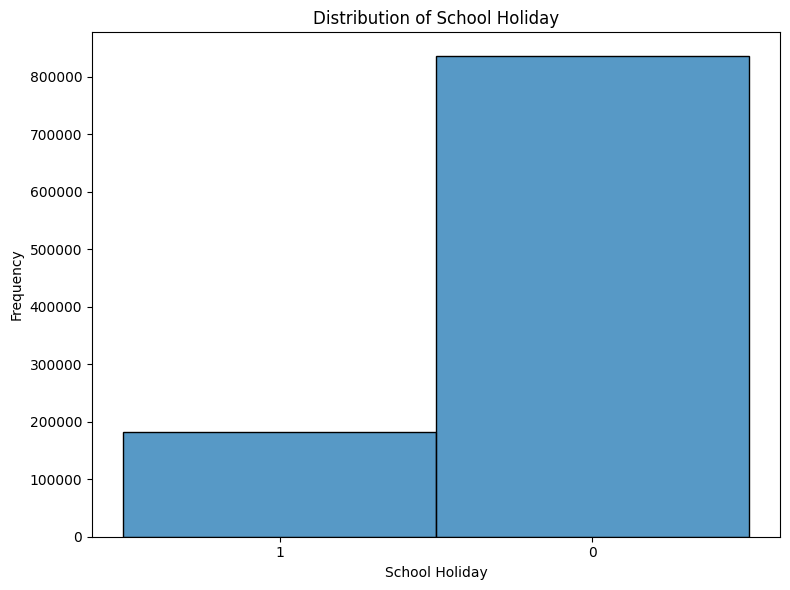

In [48]:
# SchoolHoliday
# Ensure school_holiday values are treated as strings (if necessary)
Merged_Trian_df['school_holiday'] = Merged_Trian_df['school_holiday'].astype(str)

# Create the histogram using Seaborn
plt.figure(figsize=(8, 6))
sns.histplot(Merged_Trian_df['school_holiday'], bins=10, discrete=True)  # Set discrete=True for categorical data

# Add title and labels
plt.title('Distribution of School Holiday')
plt.xlabel('School Holiday')
plt.ylabel('Frequency')

# Show the plot
plt.tight_layout()
plt.show()

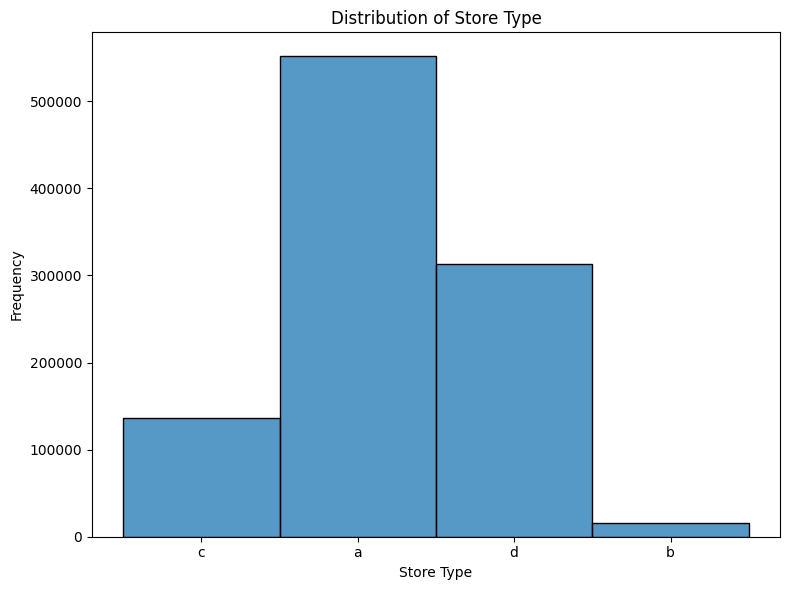

In [49]:
# CompetitionDistance
# Ensure store_type values are treated as strings (if necessary)
Merged_Trian_df['store_type'] = Merged_Trian_df['store_type'].astype(str)

# Create the histogram using Seaborn
plt.figure(figsize=(8, 6))
sns.histplot(Merged_Trian_df['store_type'], bins=len(Merged_Trian_df['store_type'].unique()), discrete=True)  # Set discrete=True for categorical data

# Add title and labels
plt.title('Distribution of Store Type')
plt.xlabel('Store Type')
plt.ylabel('Frequency')

# Show the plot
plt.tight_layout()
plt.show()

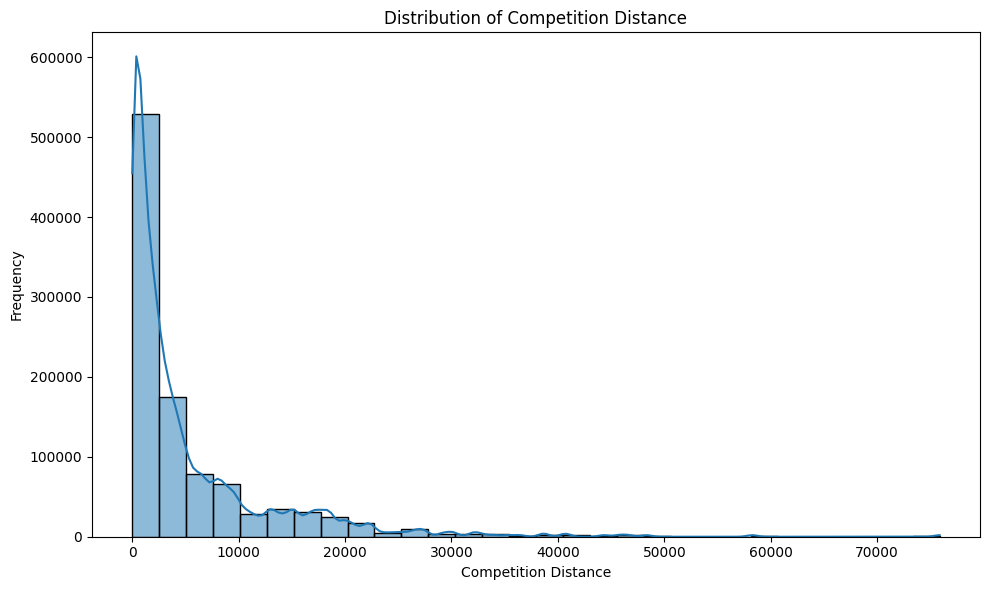

In [50]:
# CompetitionDistance
# Create the histogram using Seaborn
plt.figure(figsize=(10, 6))
sns.histplot(Merged_Trian_df['competition_distance'], bins=30, kde=True)  # Adding KDE for better visualization

# Add title and labels
plt.title('Distribution of Competition Distance')
plt.xlabel('Competition Distance')
plt.ylabel('Frequency')

# Show the plot
plt.tight_layout()
plt.show()

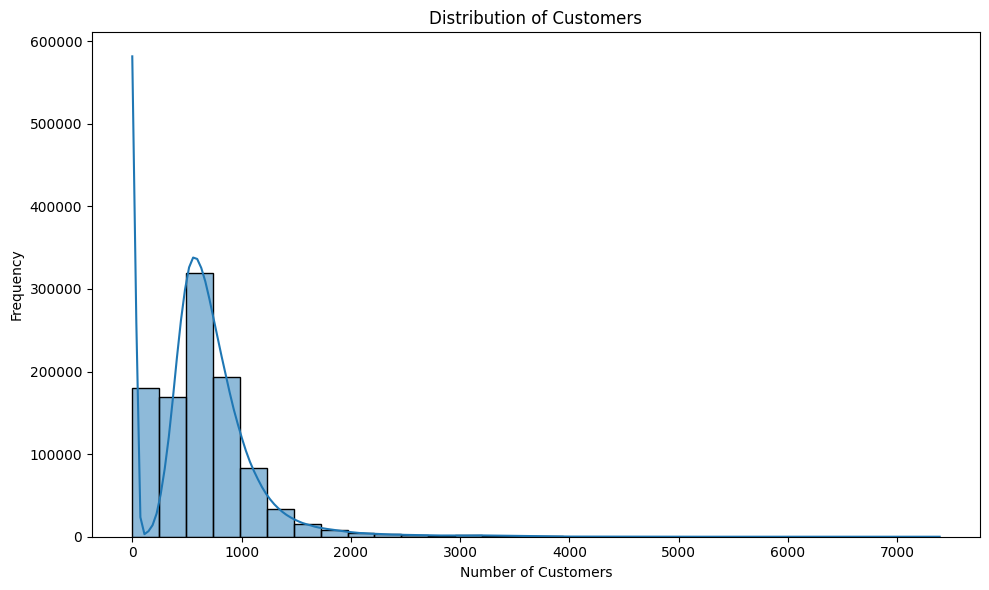

In [51]:
# Customers
# Create the histogram using Seaborn
plt.figure(figsize=(10, 6))
sns.histplot(Merged_Trian_df['customers'], bins=30, kde=True)  # Adding KDE for better visualization

# Add title and labels
plt.title('Distribution of Customers')
plt.xlabel('Number of Customers')
plt.ylabel('Frequency')

# Show the plot
plt.tight_layout()
plt.show()

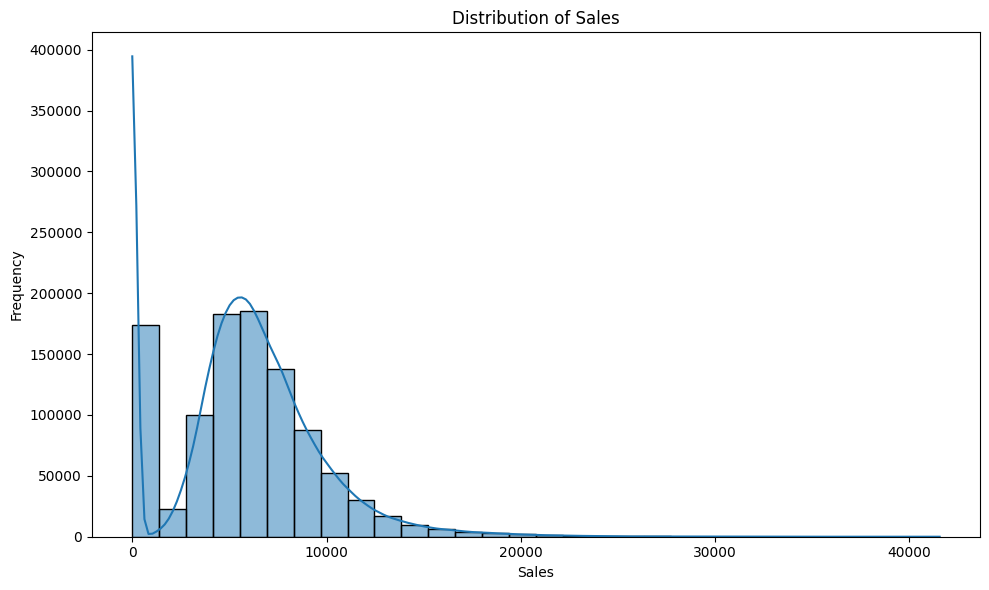

In [52]:
# Sales
# Create the histogram using Seaborn
plt.figure(figsize=(10, 6))
sns.histplot(Merged_Trian_df['sales'], bins=30, kde=True)  # Adding KDE for better visualization

# Add title and labels
plt.title('Distribution of Sales')
plt.xlabel('Sales')
plt.ylabel('Frequency')

# Show the plot
plt.tight_layout()
plt.show()

In [53]:
# 3. Temporal Variables
# Date (assuming 'Date' is already in datetime format)
Merged_Trian_df['Year'] = Merged_Trian_df['date'].dt.year
Merged_Trian_df['Month'] = Merged_Trian_df['date'].dt.month
Merged_Trian_df['Day'] = Merged_Trian_df['date'].dt.day

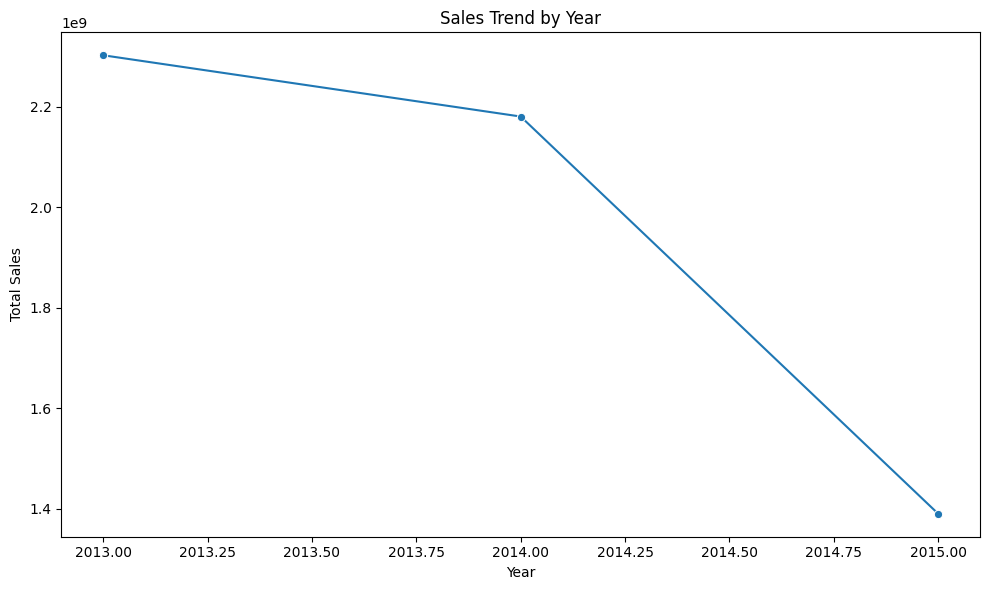

In [54]:
# Yearly Trend
# Group by 'Year' and sum 'sales'
yearly_sales = Merged_Trian_df.groupby('Year')['sales'].sum().reset_index()

# Create the line plot using Seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(data=yearly_sales, x='Year', y='sales', marker='o')

# Add title and labels
plt.title('Sales Trend by Year')
plt.xlabel('Year')
plt.ylabel('Total Sales')

# Show the plot
plt.tight_layout()
plt.show()

# Bivariate Analysis

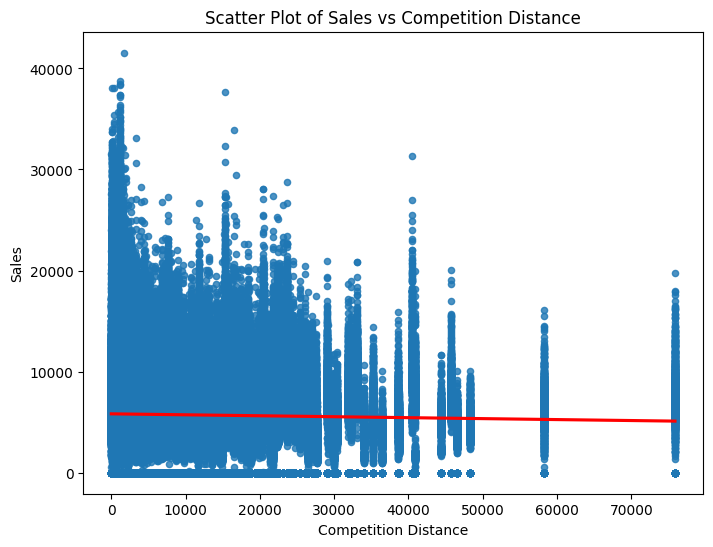

In [55]:
# Create scatter plot with Seaborn, adding a regression line
plt.figure(figsize=(8, 6))
sns.regplot(x='competition_distance', y='sales', data=df3, scatter_kws={'s': 20}, line_kws={'color': 'red'}, ci=None)

# Add title and labels
plt.title('Scatter Plot of Sales vs Competition Distance')
plt.xlabel('Competition Distance')
plt.ylabel('Sales')

# Show the plot
plt.show()

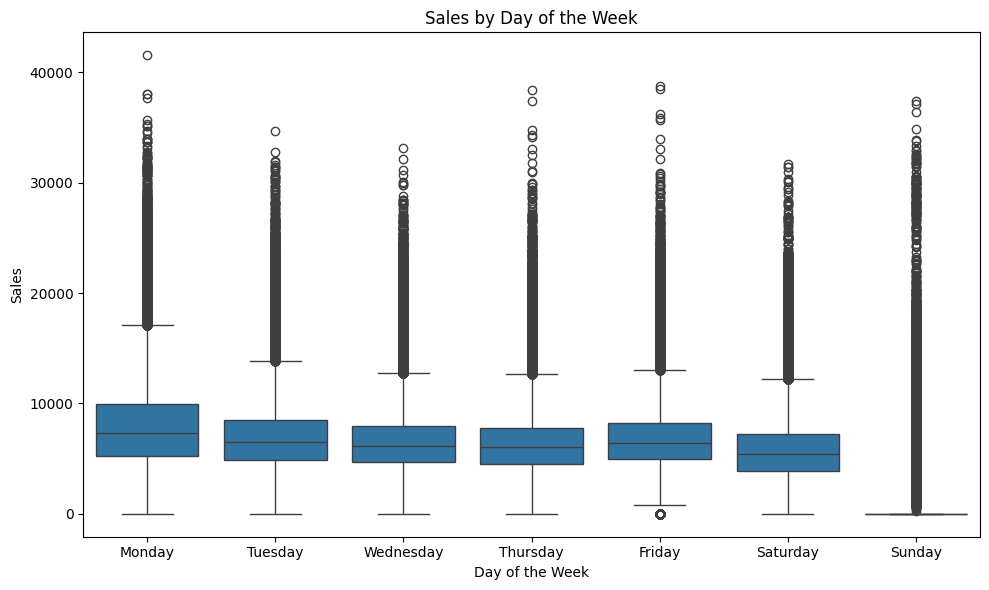

In [56]:
# Sales vs. DayOfWeek
# Create the box plot using Seaborn
plt.figure(figsize=(10, 6))
sns.boxplot(data=Merged_Trian_df, x='day_of_week', y='sales')

# Add title and labels
plt.title('Sales by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Sales')

# Customize x-axis ticks if necessary
plt.xticks(ticks=range(7), labels=[
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

# Show the plot
plt.tight_layout()
plt.show()

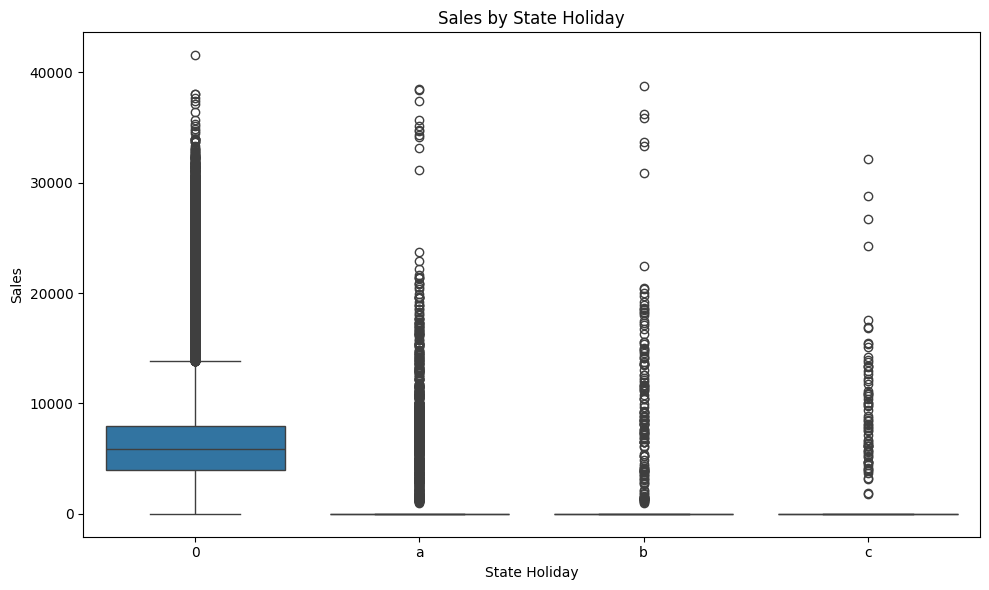

In [57]:
# Sales vs. StateHoliday
# Create the box plot using Seaborn
plt.figure(figsize=(10, 6))
sns.boxplot(data=Merged_Trian_df, x='state_holiday', y='sales')

# Add title and labels
plt.title('Sales by State Holiday')
plt.xlabel('State Holiday')
plt.ylabel('Sales')

# Show the plot
plt.tight_layout()
plt.show()

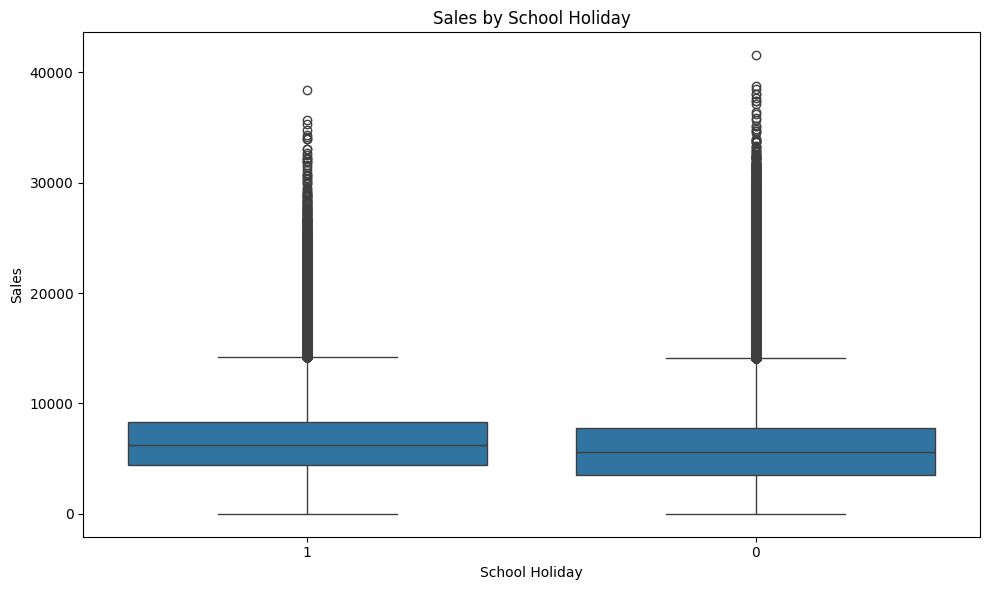

In [58]:
# Sales vs. SchoolHoliday

# Create the box plot using Seaborn
plt.figure(figsize=(10, 6))
sns.boxplot(data=Merged_Trian_df, x='school_holiday', y='sales')

# Add title and labels
plt.title('Sales by School Holiday')
plt.xlabel('School Holiday')
plt.ylabel('Sales')

# Show the plot
plt.tight_layout()
plt.show()

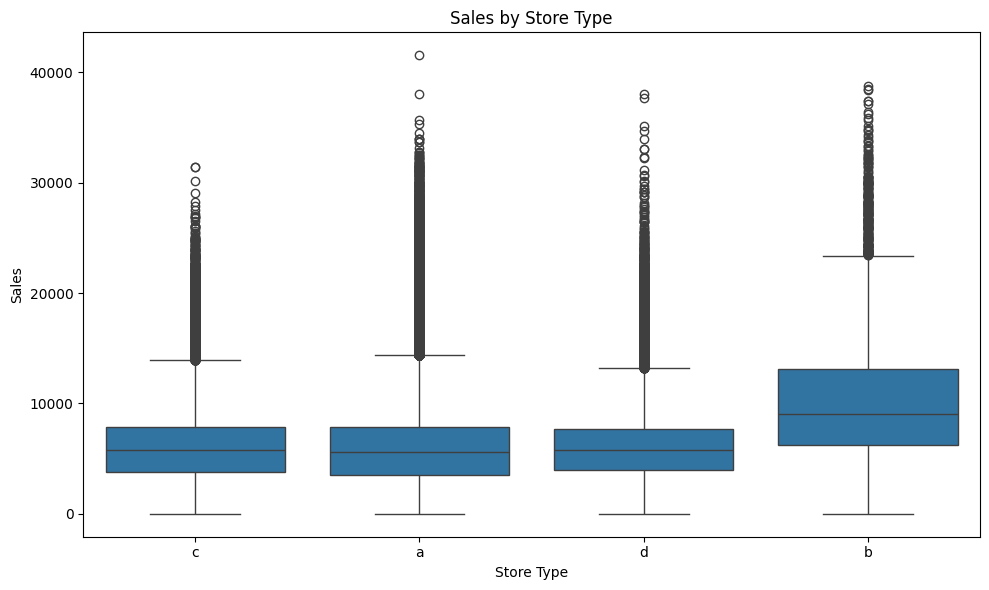

In [59]:
# Sales vs. StoreType
# Create the box plot using Seaborn
plt.figure(figsize=(10, 6))
sns.boxplot(data=Merged_Trian_df, x='store_type', y='sales')

# Add title and labels
plt.title('Sales by Store Type')
plt.xlabel('Store Type')
plt.ylabel('Sales')

# Show the plot
plt.tight_layout()
plt.show()

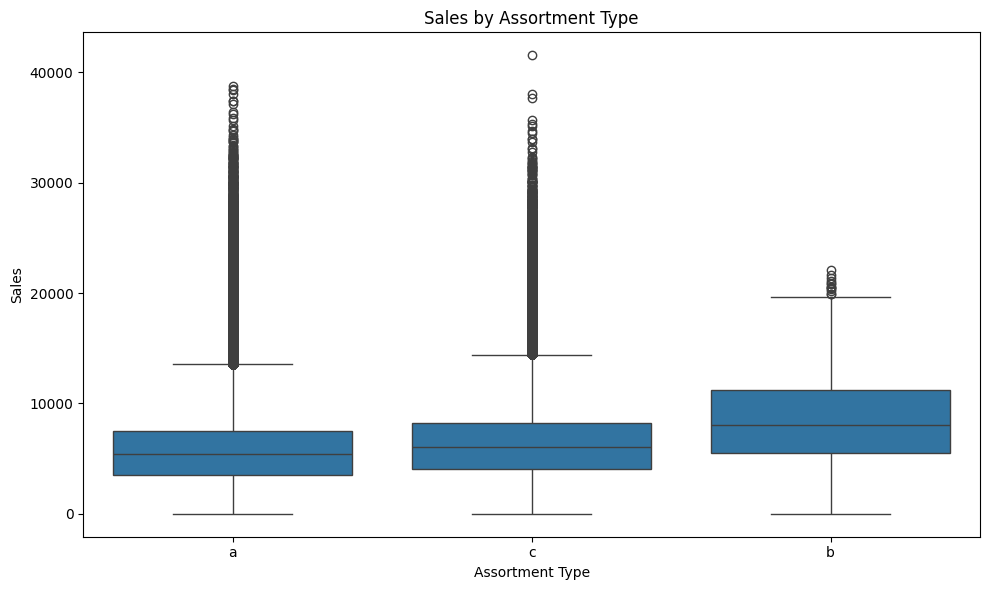

In [60]:
# Sales vs. Assortment
# Create the box plot using Seaborn
plt.figure(figsize=(10, 6))
sns.boxplot(data=Merged_Trian_df, x='assortment', y='sales')

# Add title and labels
plt.title('Sales by Assortment Type')
plt.xlabel('Assortment Type')
plt.ylabel('Sales')

# Show the plot
plt.tight_layout()
plt.show()

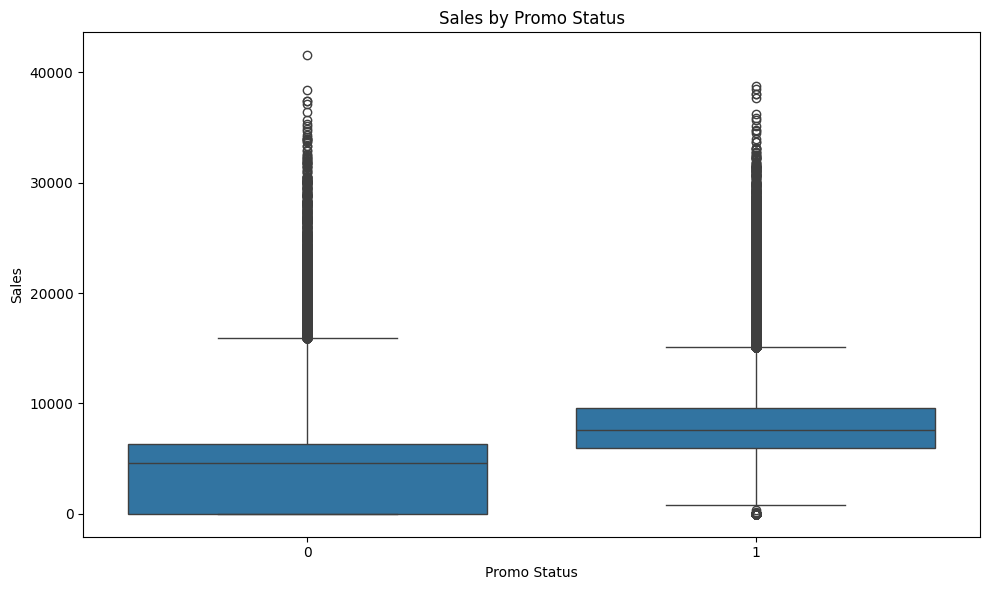

In [61]:
# Sales vs. Promo
# Create the box plot using Seaborn
plt.figure(figsize=(10, 6))
sns.boxplot(data=Merged_Trian_df, x='promo', y='sales')

# Add title and labels
plt.title('Sales by Promo Status')
plt.xlabel('Promo Status')
plt.ylabel('Sales')

# Show the plot
plt.tight_layout()
plt.show()

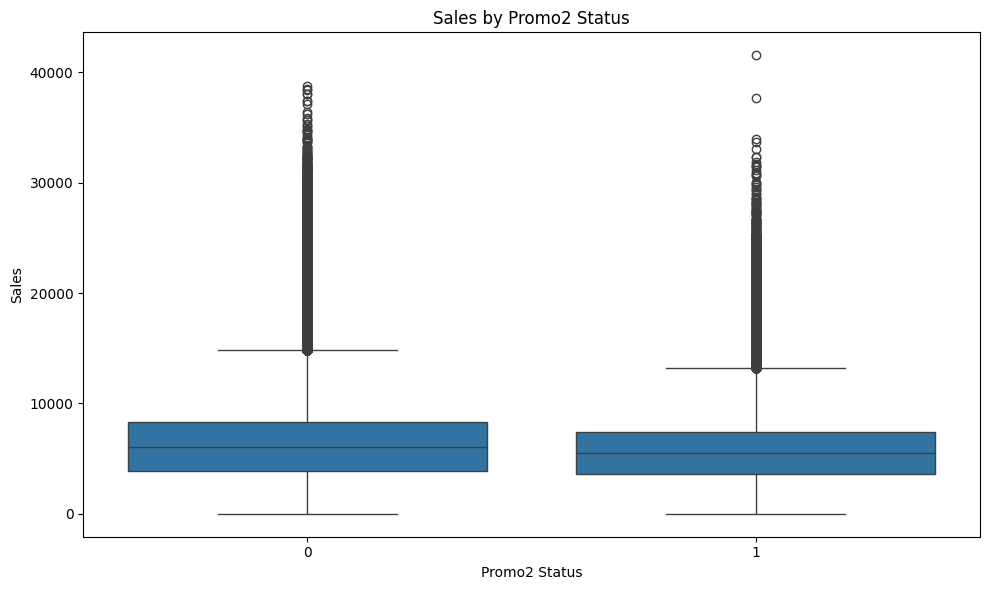

In [62]:
# Sales vs. Promo2
# Create the box plot using Seaborn
plt.figure(figsize=(10, 6))
sns.boxplot(data=Merged_Trian_df, x='promo2', y='sales')

# Add title and labels
plt.title('Sales by Promo2 Status')
plt.xlabel('Promo2 Status')
plt.ylabel('Sales')

# Show the plot
plt.tight_layout()
plt.show()

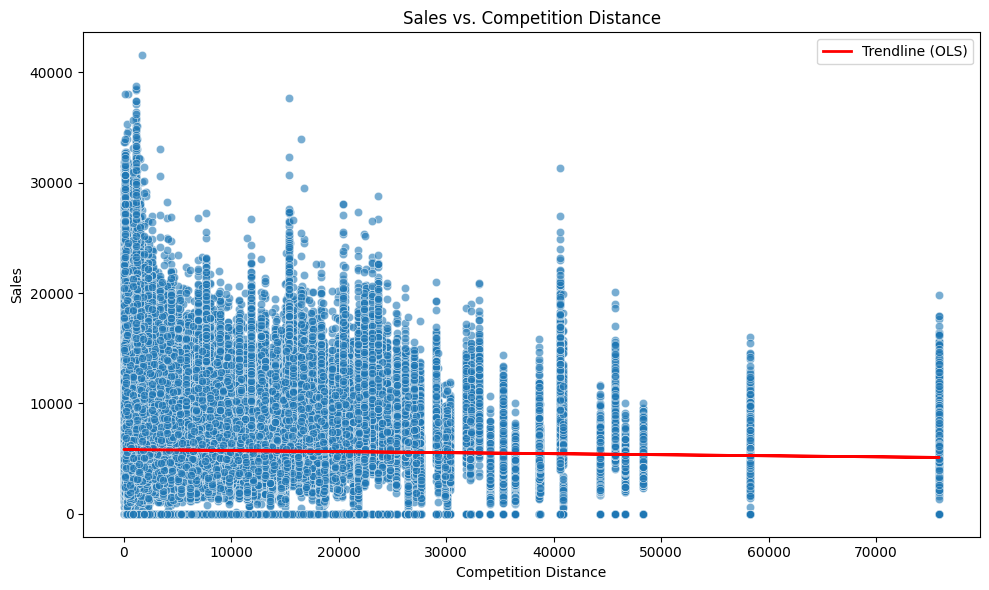

In [63]:
# Sales vs. CompetitionDistance
import statsmodels.api as sm

# Prepare the data
x = Merged_Trian_df['competition_distance']
y = Merged_Trian_df['sales']

# Create a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=x, y=y, alpha=0.6)

# Fit a linear regression model
X = sm.add_constant(x)  # Adds a constant term to the predictor
model = sm.OLS(y, X).fit()  # Fit the model
predictions = model.predict(X)

# Plot the regression line
plt.plot(x, predictions, color='red', linewidth=2, label='Trendline (OLS)')

# Add title and labels
plt.title('Sales vs. Competition Distance')
plt.xlabel('Competition Distance')
plt.ylabel('Sales')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

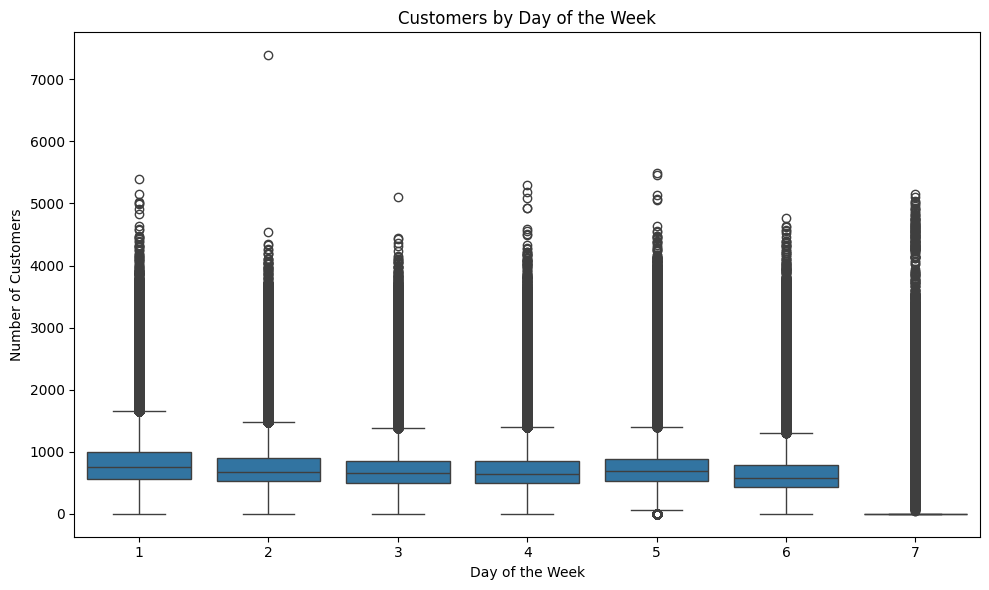

In [64]:
# 2. Customers vs. Other Variables
# Customers vs. DayOfWeek
# Create the box plot using Seaborn
plt.figure(figsize=(10, 6))
sns.boxplot(data=Merged_Trian_df, x='day_of_week', y='customers')

# Add title and labels
plt.title('Customers by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Customers')

# Show the plot
plt.tight_layout()
plt.show()

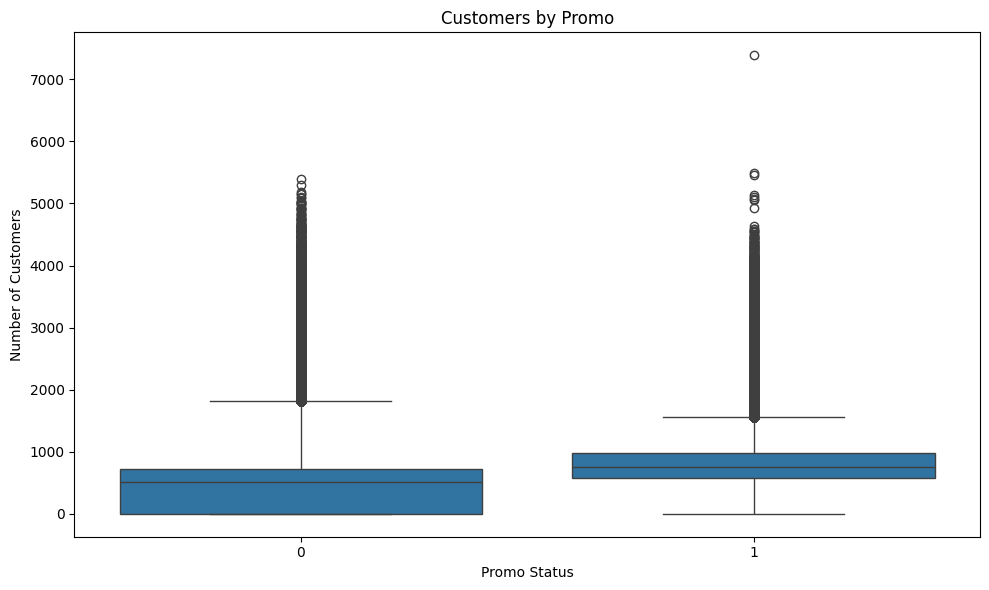

In [65]:
# Customers vs. Promo
# Create the box plot using Seaborn
plt.figure(figsize=(10, 6))
sns.boxplot(data=Merged_Trian_df, x='promo', y='customers')

# Add title and labels
plt.title('Customers by Promo')
plt.xlabel('Promo Status')  # Assuming 'promo' is binary (0 or 1)
plt.ylabel('Number of Customers')

# Show the plot
plt.tight_layout()
plt.show()

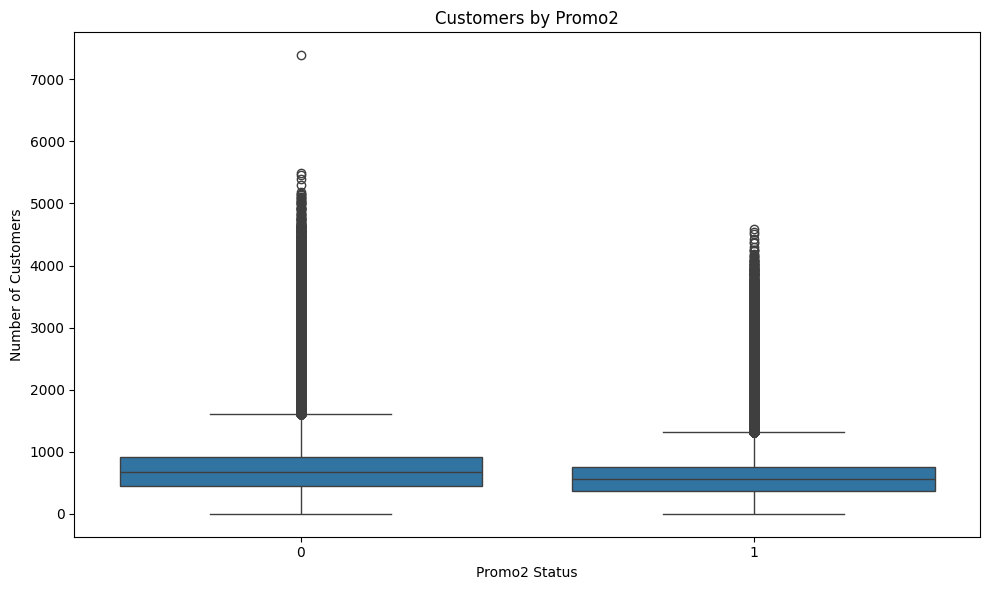

In [66]:
# Customers vs. Promo
# Create the box plot using Seaborn
plt.figure(figsize=(10, 6))
sns.boxplot(data=Merged_Trian_df, x='promo2', y='customers')

# Add title and labels
plt.title('Customers by Promo2')
plt.xlabel('Promo2 Status')  # Assuming 'promo2' is binary (0 or 1)
plt.ylabel('Number of Customers')

# Show the plot
plt.tight_layout()
plt.show()

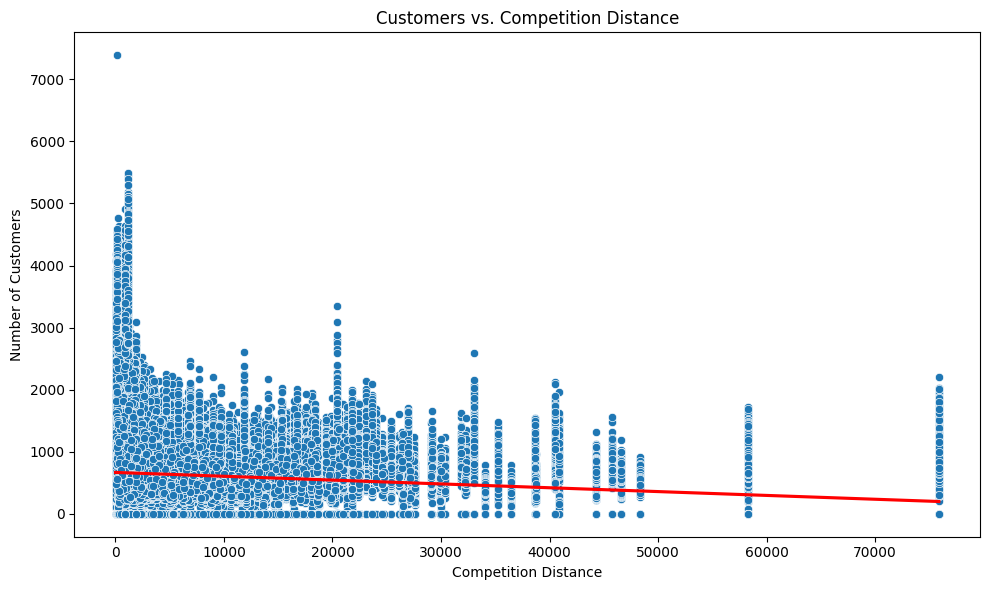

In [67]:
# Customers vs. CompetitionDistance
# Create a scatter plot using Seaborn
plt.figure(figsize=(10, 6))
sns.scatterplot(data=Merged_Trian_df, x='competition_distance', y='customers')

# Fit a linear regression line (trendline)
sns.regplot(data=Merged_Trian_df, x='competition_distance', y='customers', scatter=False, color='red')

# Add title and labels
plt.title('Customers vs. Competition Distance')
plt.xlabel('Competition Distance')
plt.ylabel('Number of Customers')

# Show the plot
plt.tight_layout()
plt.show()

# MultiVariate

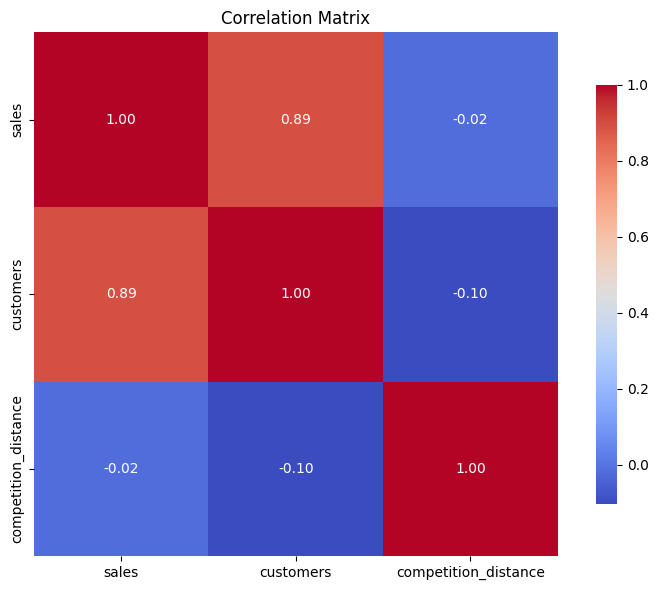

In [68]:
# 3. Correlation Analysis
# Calculate the correlation matrix
correlation_matrix = Merged_Trian_df[['sales', 'customers', 'competition_distance']].corr()

# Set up the matplotlib figure
plt.figure(figsize=(8, 6))

# Create a heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True, cbar_kws={"shrink": .8})

# Add title
plt.title('Correlation Matrix')

# Show the plot
plt.tight_layout()
plt.show()

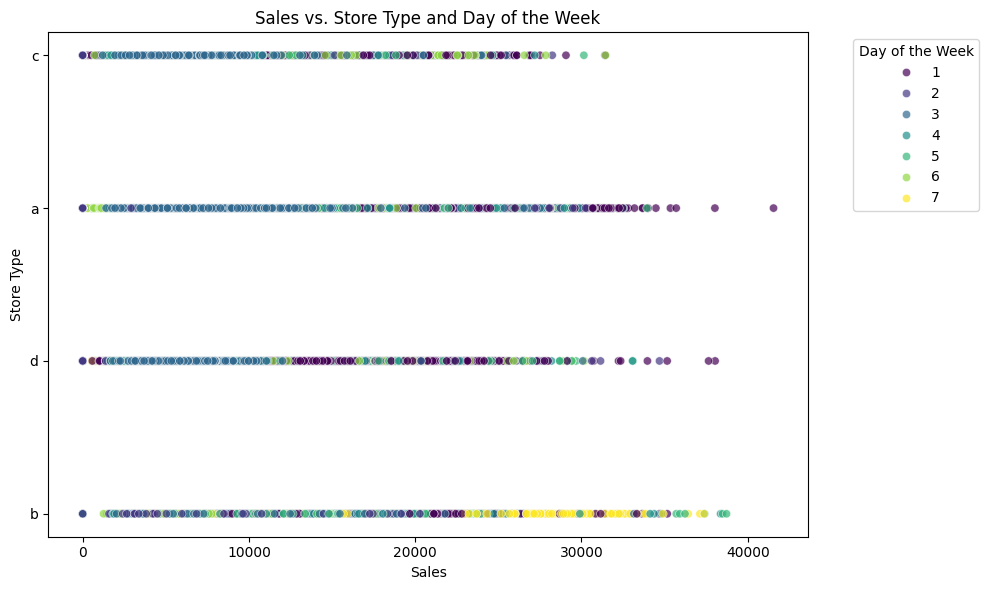

In [69]:
# Sales vs. StoreType and DayOfWeek
# Set up the figure size
plt.figure(figsize=(10, 6))

# Create the scatter plot
sns.scatterplot(data=Merged_Trian_df, x='sales', y='store_type', hue='day_of_week',
                 palette='viridis', alpha=0.7)

# Add titles and labels
plt.title('Sales vs. Store Type and Day of the Week')
plt.xlabel('Sales')
plt.ylabel('Store Type')

# Show the plot
plt.legend(title='Day of the Week', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

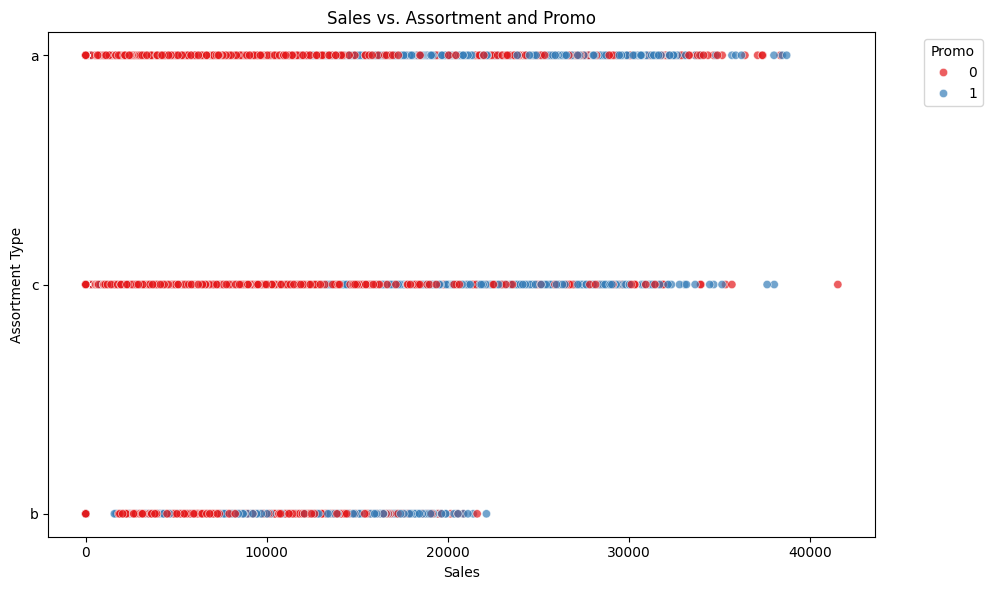

In [70]:
# Sales vs. Assortment and Promo
# Set up the figure size
plt.figure(figsize=(10, 6))

# Create the scatter plot
sns.scatterplot(data=Merged_Trian_df, x='sales', y='assortment', hue='promo',
                 palette='Set1', alpha=0.7)

# Add titles and labels
plt.title('Sales vs. Assortment and Promo')
plt.xlabel('Sales')
plt.ylabel('Assortment Type')

# Show the plot
plt.legend(title='Promo', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

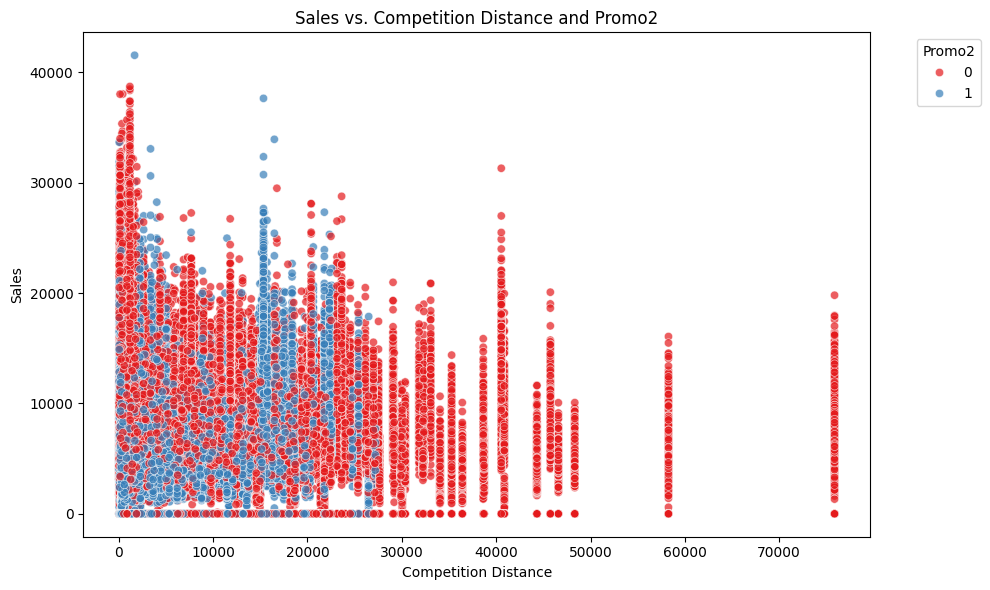

In [71]:
# Sales vs. CompetitionDistance and Promo2
# Set up the figure size
plt.figure(figsize=(10, 6))

# Create the scatter plot
sns.scatterplot(data=Merged_Trian_df, x='competition_distance', y='sales', hue='promo2',
                 palette='Set1', alpha=0.7)

# Add titles and labels
plt.title('Sales vs. Competition Distance and Promo2')
plt.xlabel('Competition Distance')
plt.ylabel('Sales')

# Show the plot
plt.legend(title='Promo2', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

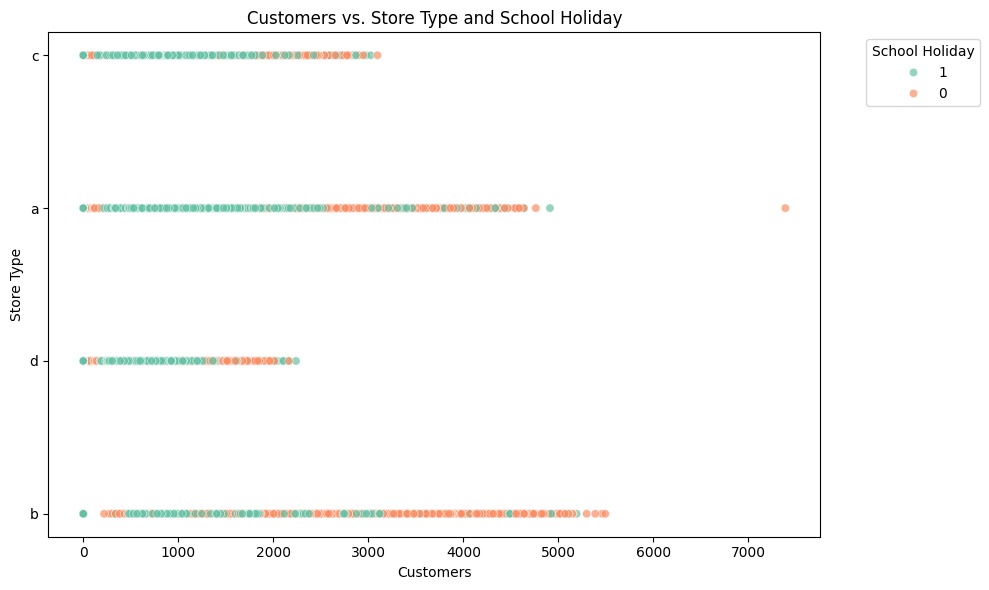

In [72]:
# Customers vs. StoreType and SchoolHoliday
# Set up the figure size
plt.figure(figsize=(10, 6))

# Create the scatter plot
sns.scatterplot(data=Merged_Trian_df, x='customers', y='store_type', hue='school_holiday',
                 palette='Set2', alpha=0.7)

# Add titles and labels
plt.title('Customers vs. Store Type and School Holiday')
plt.xlabel('Customers')
plt.ylabel('Store Type')

# Show the plot
plt.legend(title='School Holiday', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

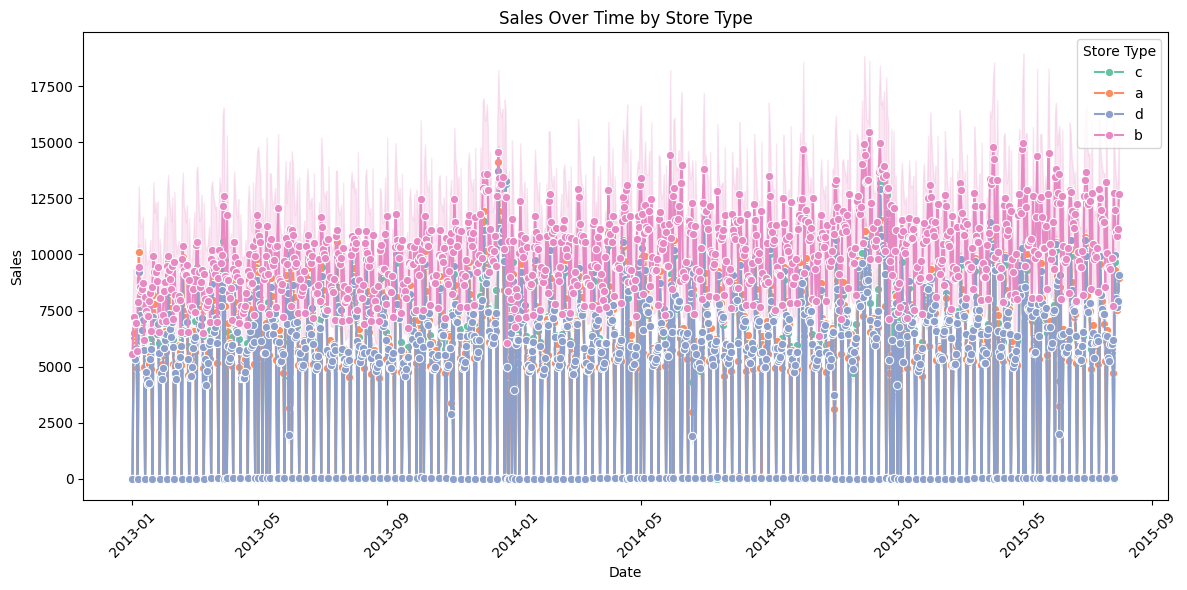

In [73]:
# Sales Over Time by StoreType
# Convert the 'date' column to datetime if it's not already
Merged_Trian_df['date'] = pd.to_datetime(Merged_Trian_df['date'])

# Set up the figure size
plt.figure(figsize=(12, 6))

# Create the line plot
sns.lineplot(data=Merged_Trian_df, x='date', y='sales', hue='store_type',
             marker='o', palette='Set2')

# Add titles and labels
plt.title('Sales Over Time by Store Type')
plt.xlabel('Date')
plt.ylabel('Sales')

# Show the plot
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend(title='Store Type')
plt.tight_layout()
plt.show()

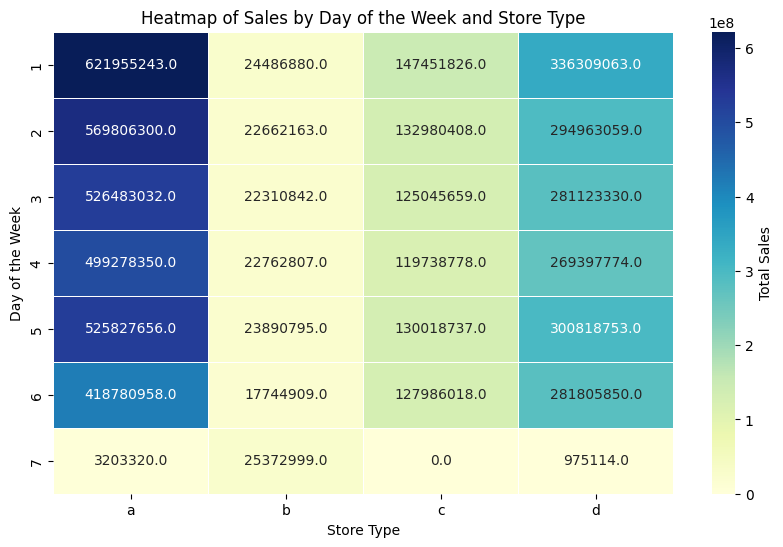

In [74]:
# Heatmap of Sales and Customers by DayOfWeek and StoreType
# Assuming Merged_Trian_df is your DataFrame
# Create a pivot table for the heatmap
pivot_table = Merged_Trian_df.pivot_table(values='sales',
                                           index='day_of_week',
                                           columns='store_type',
                                           aggfunc='sum')

# Set up the figure size
plt.figure(figsize=(10, 6))

# Create the heatmap
sns.heatmap(pivot_table,
            cmap='YlGnBu',
            annot=True,  # Show values on the heatmap
            fmt=".1f",   # Format of the annotation
            linewidths=0.5,
            cbar_kws={'label': 'Total Sales'})  # Color bar label

# Add titles and labels
plt.title('Heatmap of Sales by Day of the Week and Store Type')
plt.xlabel('Store Type')
plt.ylabel('Day of the Week')

# Show the plot
plt.show()

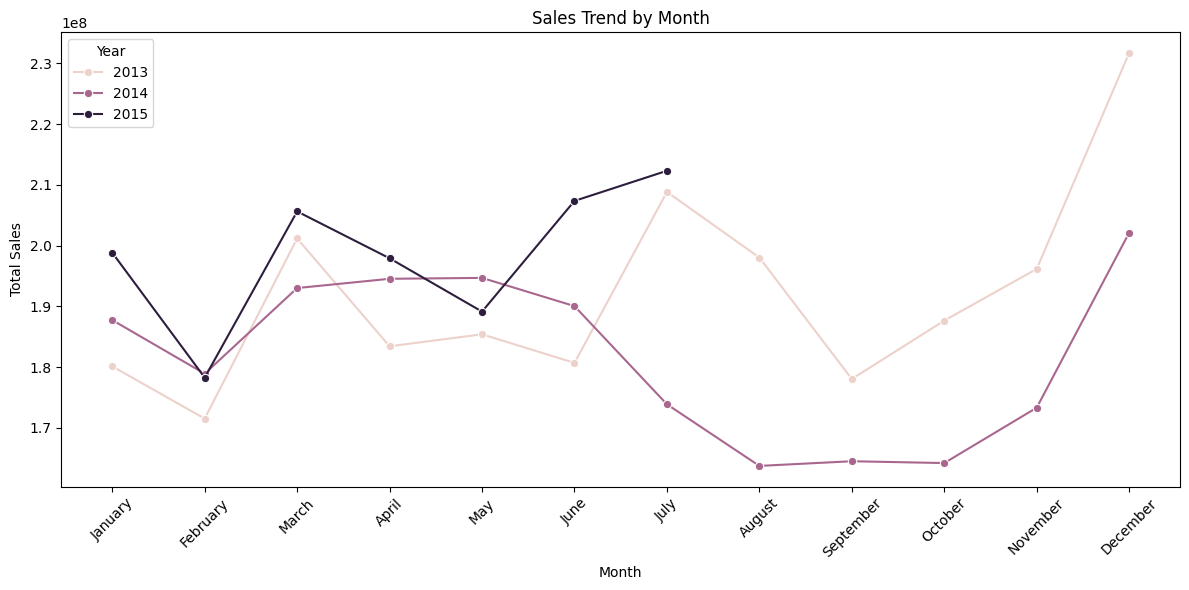

In [75]:
# Monthly Trend
# Group by 'Year' and 'Month' and sum 'sales'
monthly_sales = Merged_Trian_df.groupby(['Year', 'Month'])['sales'].sum().reset_index()

# Create the line plot using Seaborn
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_sales, x='Month', y='sales', hue='Year', marker='o')

# Add title and labels
plt.title('Sales Trend by Month')
plt.xlabel('Month')
plt.ylabel('Total Sales')

# Customize x-axis ticks for better readability
plt.xticks(ticks=range(1, 13), labels=[
    'January', 'February', 'March', 'April', 'May', 'June',
    'July', 'August', 'September', 'October', 'November', 'December'], rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

# QN Explore the data

In [76]:
Merged_Trian_df.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval', 'Year', 'Month', 'Day'],
      dtype='object')

In [77]:
Merged_Trian_df["sales_per_customer"]=Merged_Trian_df["sales"]/Merged_Trian_df['customers']

In [78]:
# %%
for col in Merged_Trian_df.columns:
    if col != 'date' and col != 'competition_distance':
        print(col, Merged_Trian_df[col].unique())


store [   1    2    3 ... 1113 1114 1115]
day_of_week [5 4 3 2 1 7 6]
sales [ 5263  6064  8314 ...   660 17815 23303]
customers [ 555  625  821 ... 3900   36 4065]
open [1 0]
promo [1 0]
state_holiday ['0' 'a' 'b' 'c']
school_holiday ['1' '0']
store_type ['c' 'a' 'd' 'b']
assortment ['a' 'c' 'b']
competition_open_since_month [ 9 11 12  4 10  8  5  3  7  6  2  1]
competition_open_since_year [2008 2007 2006 2009 2015 2013 2014 2000 2011 2012 2010 2005 1999 2002
 2003 2004 1988 1974 1961 1984 1995 2001 1990 1994 1900 1953 1998 1997
 1996]
promo2 [0 1]
promo2_since_week [ 0 13 14  1 45 40 26 22  5  6 10 31 37  9 39 27 18 35 23 48 36 50 44 49
 28]
promo2_since_year [   0 2010 2011 2012 2009 2014 2015 2013]
promo_interval ['Missing' 'Jan,Apr,Jul,Oct' 'Feb,May,Aug,Nov' 'Mar,Jun,Sept,Dec']
Year [2015 2014 2013]
Month [ 7  6  5  4  3  2  1 12 11 10  9  8]
Day [31 30 29 28 27 26 25 24 23 22 21 20 19 18 17 16 15 14 13 12 11 10  9  8
  7  6  5  4  3  2  1]
sales_per_customer [ 9.48288288  9.7024  

# # 1. What is the overall trend of sales over time?


In [79]:
# %% [markdown]


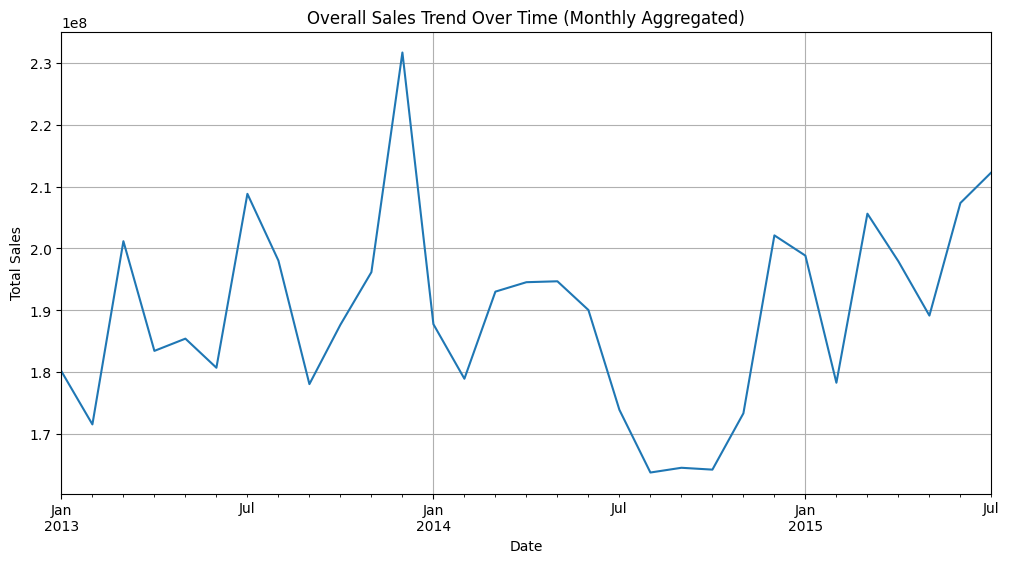

In [80]:
#
Merged_Trian_df['date'] = pd.to_datetime(Merged_Trian_df['date'])
Merged_Trian_df.set_index('date', drop=False, inplace=True)

monthly_sales = Merged_Trian_df['sales'].resample('M').sum()

monthly_sales.plot(figsize=(12, 6))
plt.title('Overall Sales Trend Over Time (Monthly Aggregated)')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.grid(True)
plt.show()

# # 2. Which stores have the highest and lowest average sales?


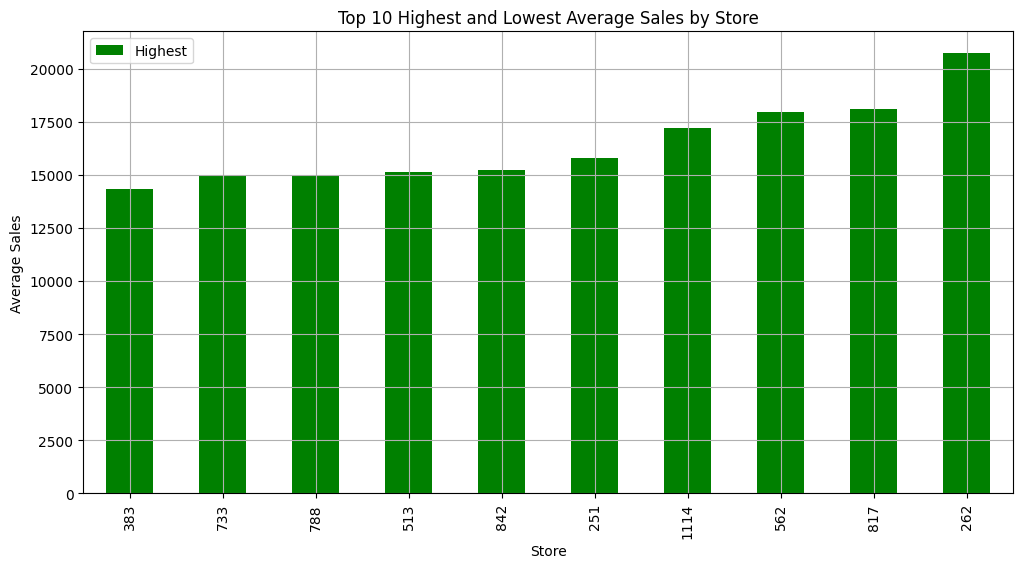

In [81]:
# %%
Merged_Trian_df['date']


# %%
store_sales = Merged_Trian_df.groupby('store')['sales'].mean().sort_values()

fig, ax = plt.subplots(figsize=(12, 6))
store_sales.tail(10).plot(kind='bar', ax=ax, color='green', label='Highest')

plt.title('Top 10 Highest and Lowest Average Sales by Store')
plt.xlabel('Store')
plt.ylabel('Average Sales')
plt.legend()
plt.grid(True)
plt.show()

# # 3. How do sales differ across different store types?


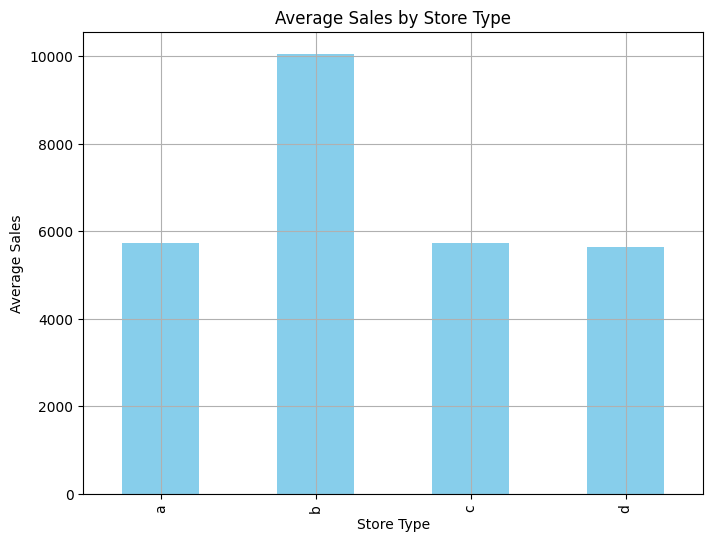

In [82]:

# %%
store_type_sales = Merged_Trian_df.groupby('store_type')['sales'].mean()

store_type_sales.plot(kind='bar', figsize=(8, 6), color='skyblue')
plt.title('Average Sales by Store Type')
plt.xlabel('Store Type')
plt.ylabel('Average Sales')
plt.grid(True)
plt.show()

# # 4. How do promotions impact sales?


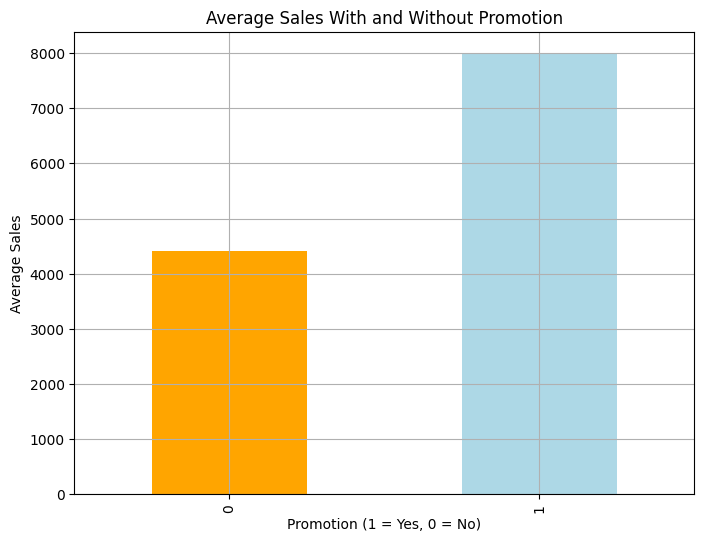

In [83]:

# %%
promo_sales = Merged_Trian_df.groupby('promo')['sales'].mean()

promo_sales.plot(kind='bar', figsize=(8, 6), color=['orange', 'lightblue'])
plt.title('Average Sales With and Without Promotion')
plt.xlabel('Promotion (1 = Yes, 0 = No)')
plt.ylabel('Average Sales')
plt.grid(True)
plt.show()

# # 5. Which stores have the most loyal customer base (based on Sales per Customer)?


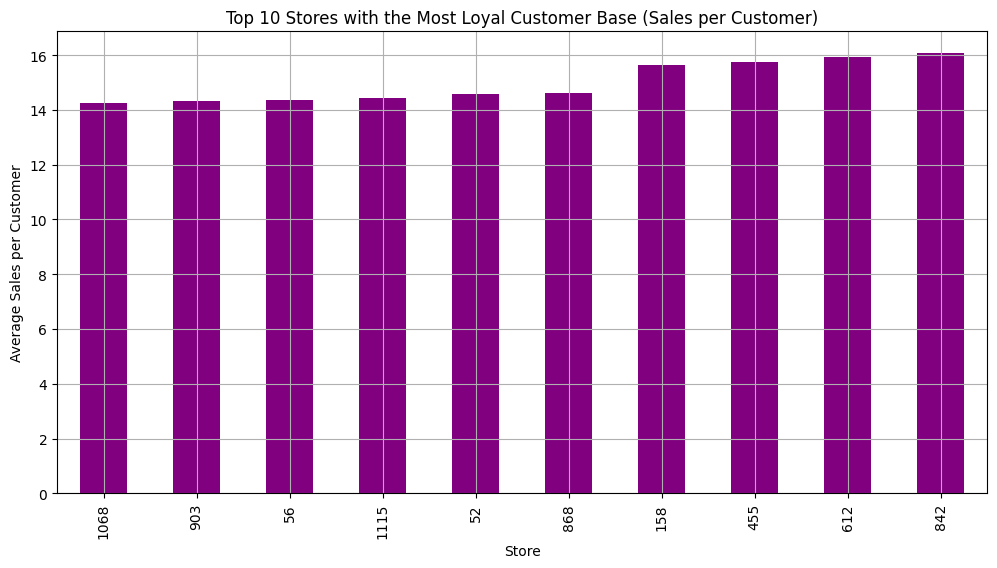

In [84]:

# %%
store_loyalty = Merged_Trian_df.groupby('store')['sales_per_customer'].mean().sort_values()

# Plot only top 10 most loyal customers
store_loyalty.tail(10).plot(kind='bar', figsize=(12, 6), color='purple')
plt.title('Top 10 Stores with the Most Loyal Customer Base (Sales per Customer)')
plt.xlabel('Store')
plt.ylabel('Average Sales per Customer')
plt.grid(True)
plt.show()


# # 6. How does competition impact store sales?


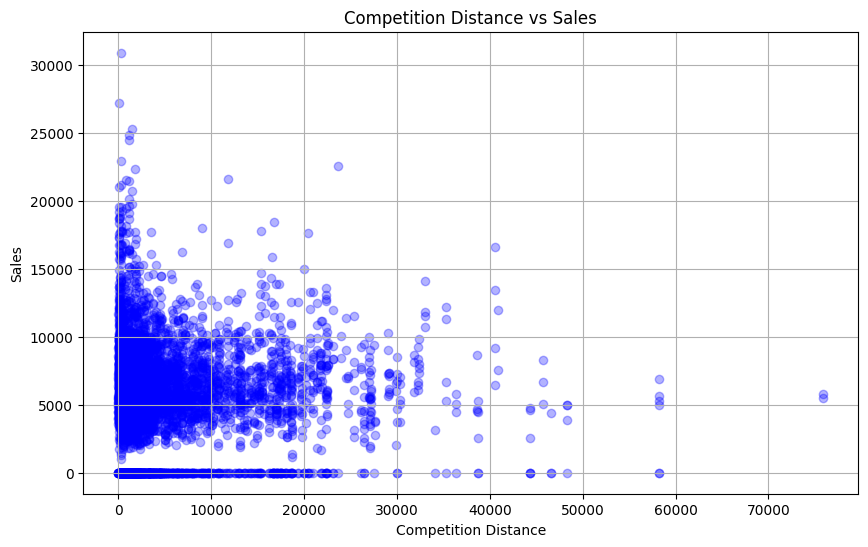

In [85]:

# %%
# Downsample for clarity
sampled_df = Merged_Trian_df.sample(5000)
plt.figure(figsize=(10, 6))
plt.scatter(sampled_df['competition_distance'], sampled_df['sales'], alpha=0.3, color='blue')
plt.title('Competition Distance vs Sales')
plt.xlabel('Competition Distance')
plt.ylabel('Sales')
plt.grid(True)
plt.show()

# # 7. How does the number of customers change across days of the week?

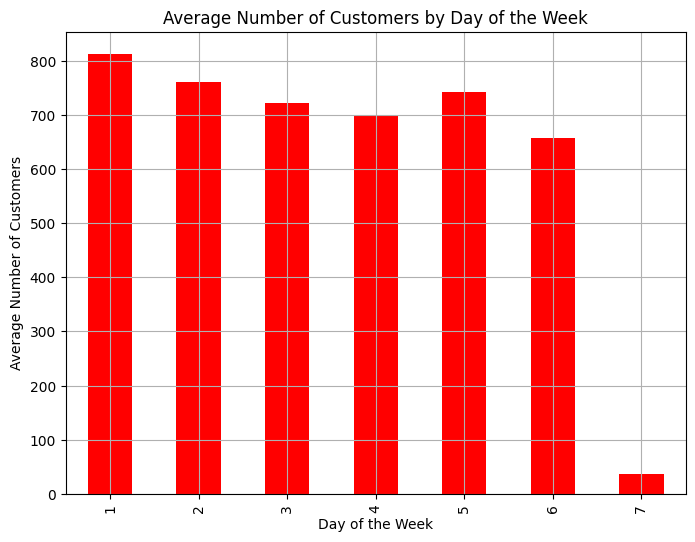

In [86]:


# %%
customers_per_day = Merged_Trian_df.groupby('day_of_week')['customers'].mean()

customers_per_day.plot(kind='bar', figsize=(8, 6), color='red')
plt.title('Average Number of Customers by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Average Number of Customers')
plt.grid(True)
plt.show()


# # 8. Which factors influence the number of customers in stores the most?


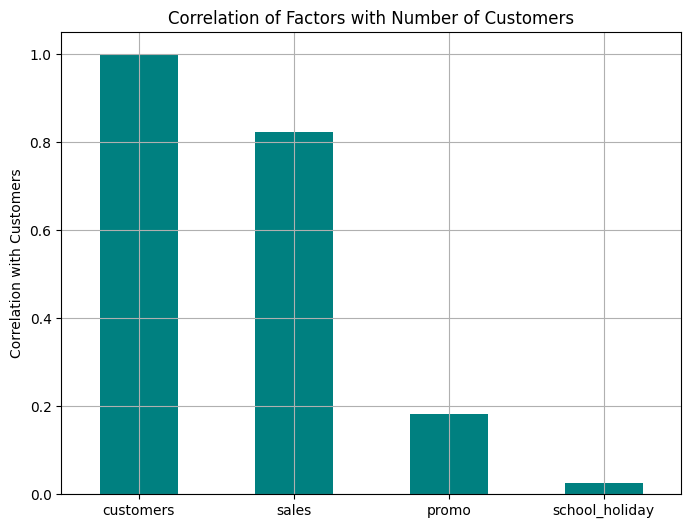

In [87]:

# %%
correlation = df[['sales', 'promo', 'school_holiday', 'customers']].corr()['customers'].sort_values(ascending=False)

correlation.plot(kind='bar', figsize=(8, 6), color='teal')
plt.title('Correlation of Factors with Number of Customers')
plt.ylabel('Correlation with Customers')
plt.xticks(rotation=0)
plt.grid(True)
plt.show()

# # 9. Are customers more likely to visit a store during a promotion?


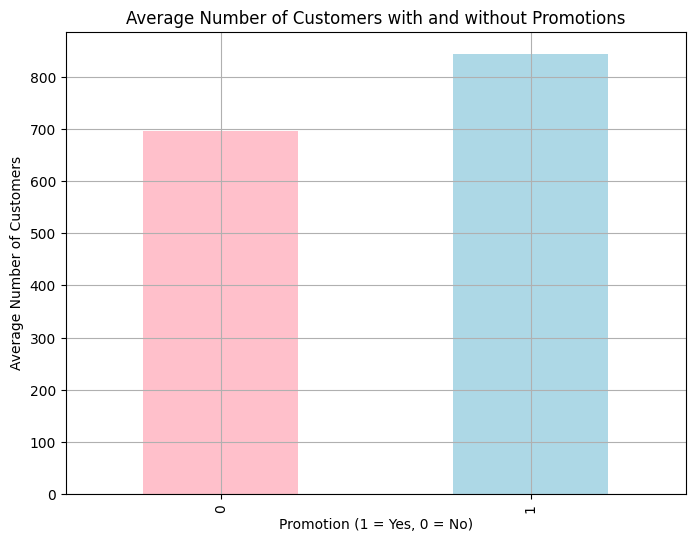

In [88]:
# %%
promo_customers = df.groupby('promo')['customers'].mean()

promo_customers.plot(kind='bar', figsize=(8, 6), color=['pink', 'lightblue'])
plt.title('Average Number of Customers with and without Promotions')
plt.xlabel('Promotion (1 = Yes, 0 = No)')
plt.ylabel('Average Number of Customers')
plt.grid(True)
plt.show()

# # 10. Do holidays impact store sales?


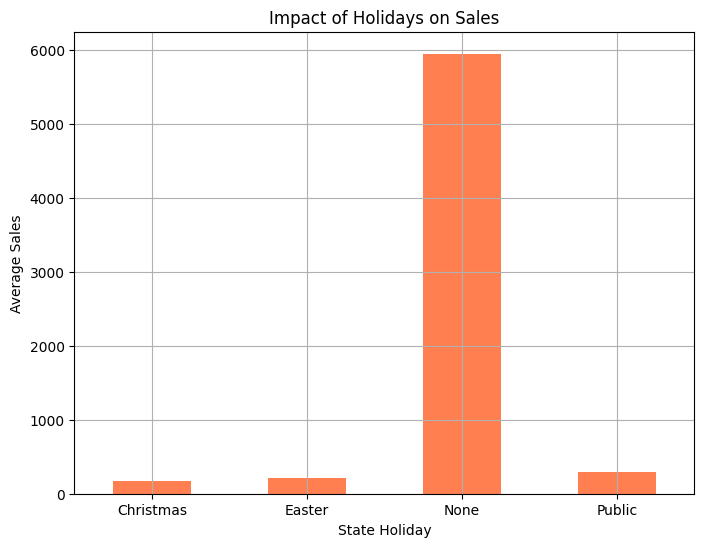

In [89]:
Merged_Trian_df['state_holiday'].replace('0', 0, inplace=True)
Merged_Trian_df['state_holiday'] = Merged_Trian_df['state_holiday'].map({0: 'None', 'a': 'Public', 'b': 'Easter', 'c': 'Christmas'})
holiday_sales = Merged_Trian_df.groupby('state_holiday')['sales'].mean()

holiday_sales.plot(kind='bar', figsize=(8, 6), color='coral')
plt.title('Impact of Holidays on Sales')
plt.xlabel('State Holiday')
plt.ylabel('Average Sales')
plt.xticks(rotation=0)
plt.grid(True)
plt.show()

# # 11. How does Promo2 and PromoInterval affect sales over time?


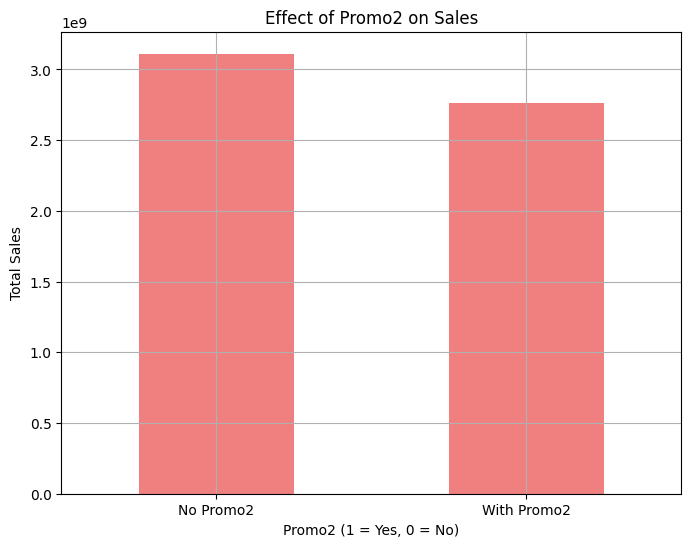

In [90]:
# %%
Merged_Trian_df['state_holiday'].unique()


# %%
promo2_sales = Merged_Trian_df.groupby('promo2')['sales'].sum()

plt.figure(figsize=(8, 6))
promo2_sales.plot(kind='bar', color='lightcoral')
plt.title('Effect of Promo2 on Sales')
plt.xlabel('Promo2 (1 = Yes, 0 = No)')
plt.ylabel('Total Sales')
plt.xticks(ticks=[0, 1], labels=['No Promo2', 'With Promo2'], rotation=0)
plt.grid()
plt.show()

# # 12. How does the assortment offered by a store affect sales?


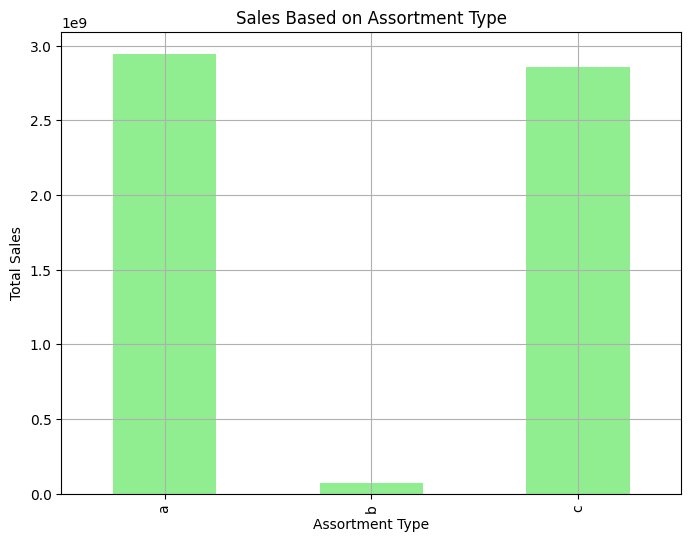

In [91]:

# %%
sales_by_assortment = Merged_Trian_df.groupby('assortment')['sales'].sum()

plt.figure(figsize=(8, 6))
sales_by_assortment.plot(kind='bar', color='lightgreen')
plt.title('Sales Based on Assortment Type')
plt.xlabel('Assortment Type')
plt.ylabel('Total Sales')
plt.grid()
plt.show()

# # 13. How does the competition open since year affect sales?


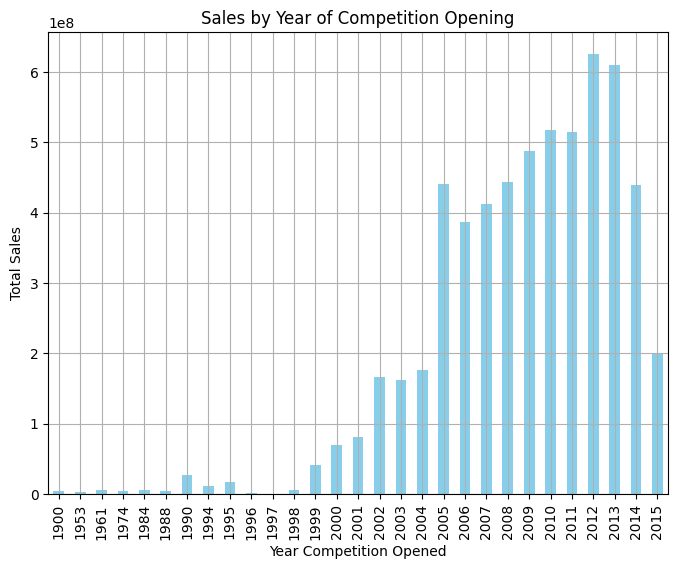

In [92]:
plt.figure(figsize=(8, 6))
competition_year_sales = Merged_Trian_df.groupby('competition_open_since_year')['sales'].sum()
competition_year_sales.plot(kind='bar', color='skyblue')
plt.title('Sales by Year of Competition Opening')
plt.xlabel('Year Competition Opened')
plt.ylabel('Total Sales')
plt.grid()
plt.show()


# # 14. Are there any outliers in sales data?


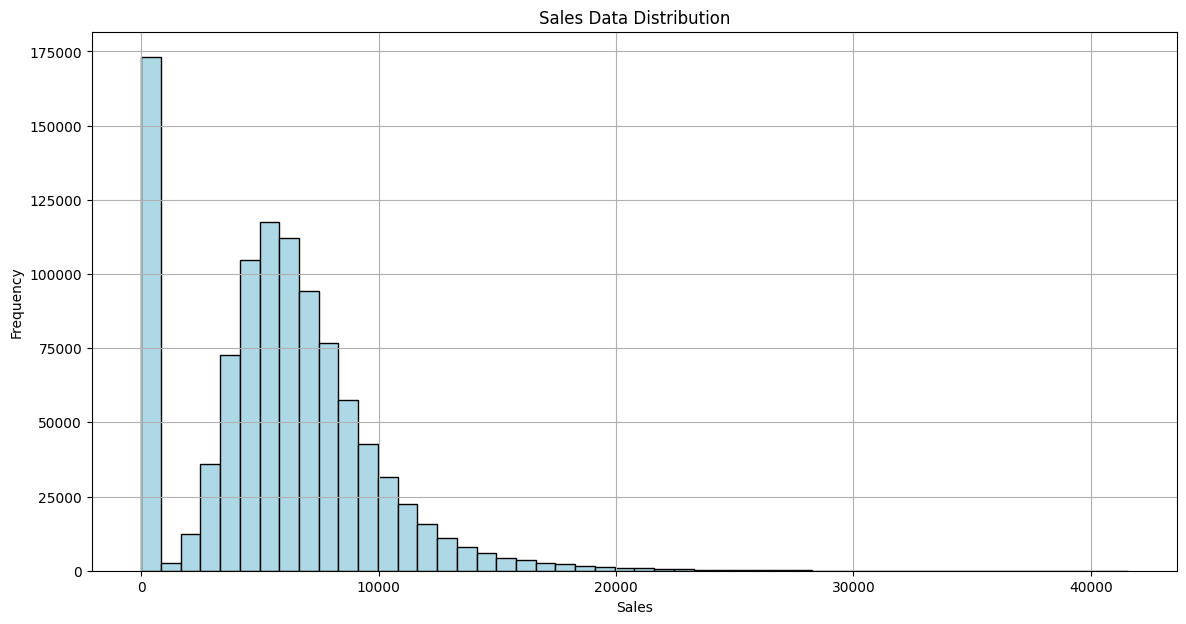

In [93]:

# %%
plt.figure(figsize=(14, 7))
plt.hist(Merged_Trian_df['sales'], bins=50, color='lightblue', edgecolor='black')
plt.title('Sales Data Distribution')
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.grid()
plt.show()

# # 15. How do sales differ by season?


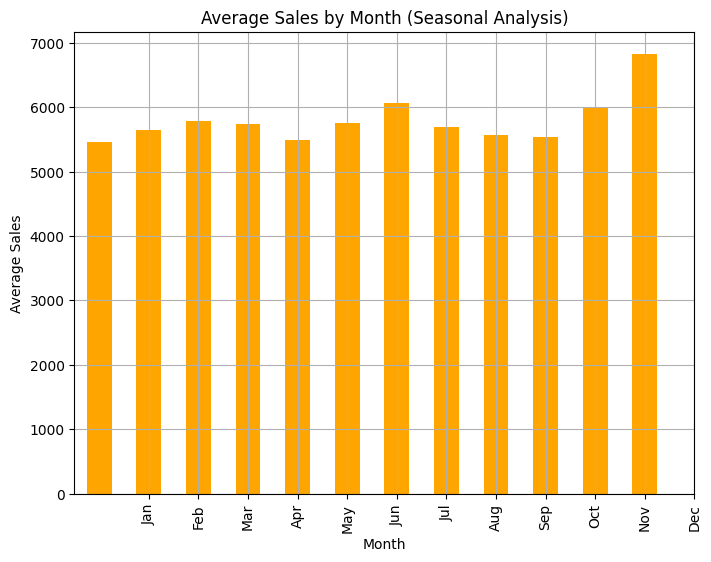

In [94]:

# %%
Merged_Trian_df['Month'] = Merged_Trian_df['date'].dt.month
avg_sales_by_month = Merged_Trian_df.groupby('Month')['sales'].mean()

plt.figure(figsize=(8, 6))
avg_sales_by_month.plot(kind='bar', color='orange')
plt.title('Average Sales by Month (Seasonal Analysis)')
plt.xlabel('Month')
plt.ylabel('Average Sales')
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid()
plt.show()


# # 16. How do sales vary from year to year?


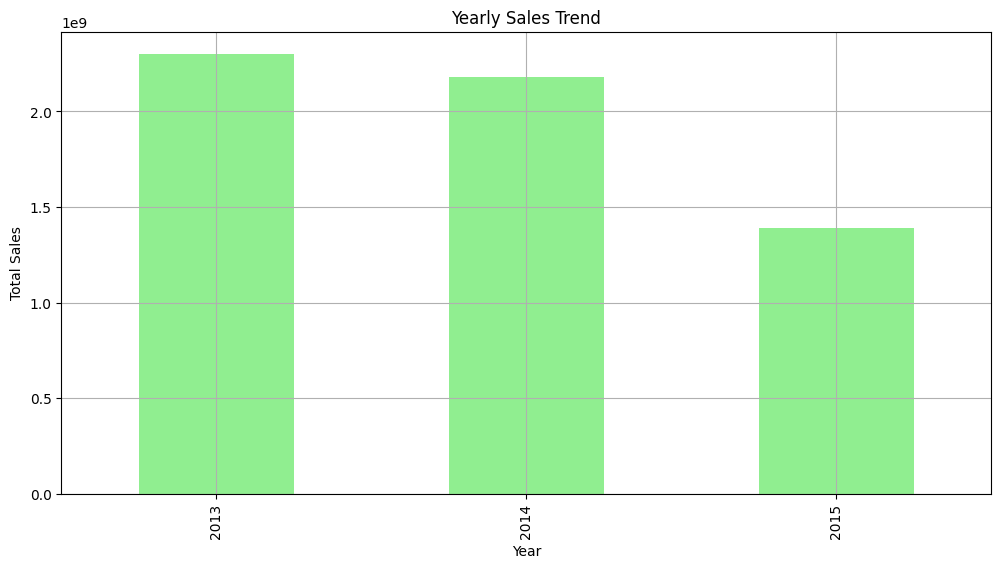

In [95]:
Merged_Trian_df['Year'] = Merged_Trian_df['date'].dt.year
yearly_sales = Merged_Trian_df.groupby('Year')['sales'].sum()

plt.figure(figsize=(12, 6))
yearly_sales.plot(kind='bar', color='lightgreen')
plt.title('Yearly Sales Trend')
plt.xlabel('Year')
plt.ylabel('Total Sales')
plt.grid()
plt.show()

# # 17. How does the average sales value change during different promotional intervals?


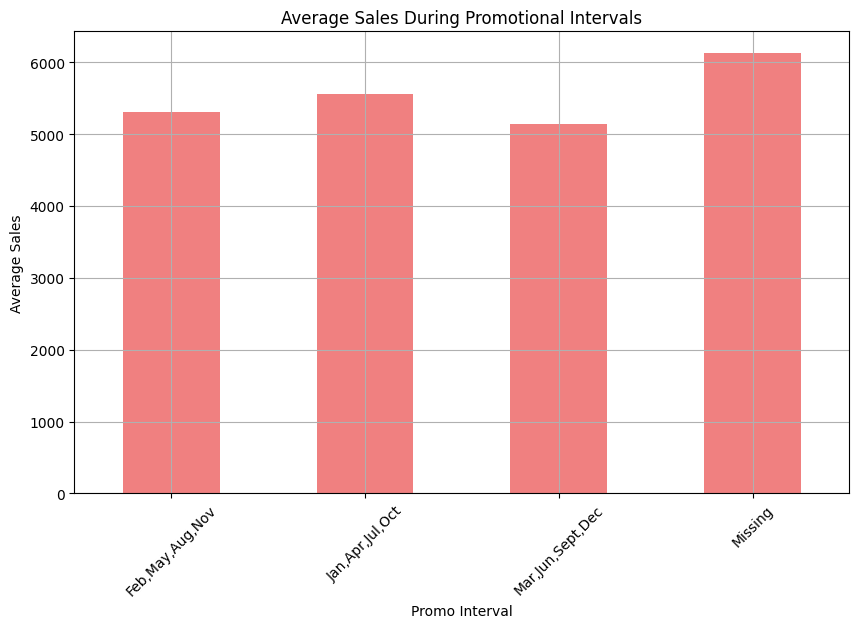

In [96]:
avg_sales_promo_interval = Merged_Trian_df.groupby('promo_interval')['sales'].mean()

plt.figure(figsize=(10, 6))
avg_sales_promo_interval.plot(kind='bar', color='lightcoral')
plt.title('Average Sales During Promotional Intervals')
plt.xlabel('Promo Interval')
plt.ylabel('Average Sales')
plt.xticks(rotation=45)
plt.grid()
plt.show()

# # 18. What is the relationship between customer count and total sales across different store types?


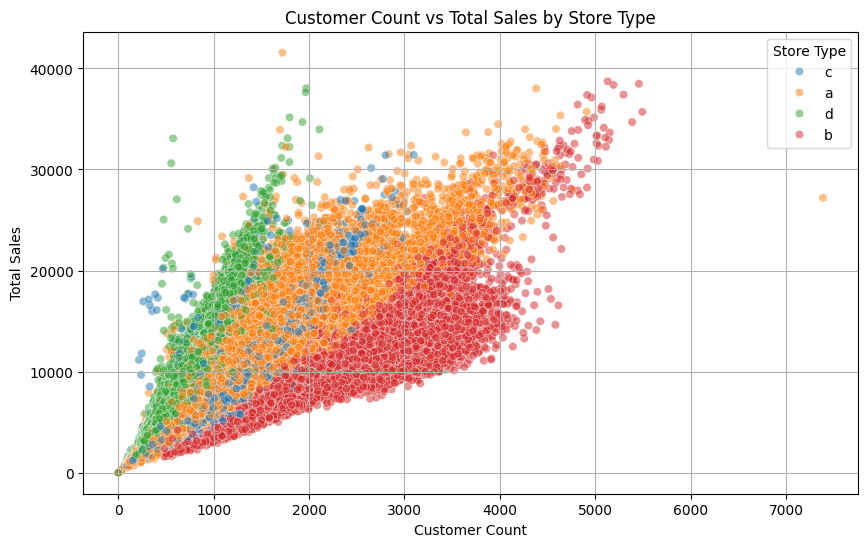

In [97]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=Merged_Trian_df, x='customers', y='sales', hue='store_type', alpha=0.5)
plt.title('Customer Count vs Total Sales by Store Type')
plt.xlabel('Customer Count')
plt.ylabel('Total Sales')
plt.grid()
plt.legend(title='Store Type')
plt.show()

# # 19. How does the average competition distance vary across different store types?


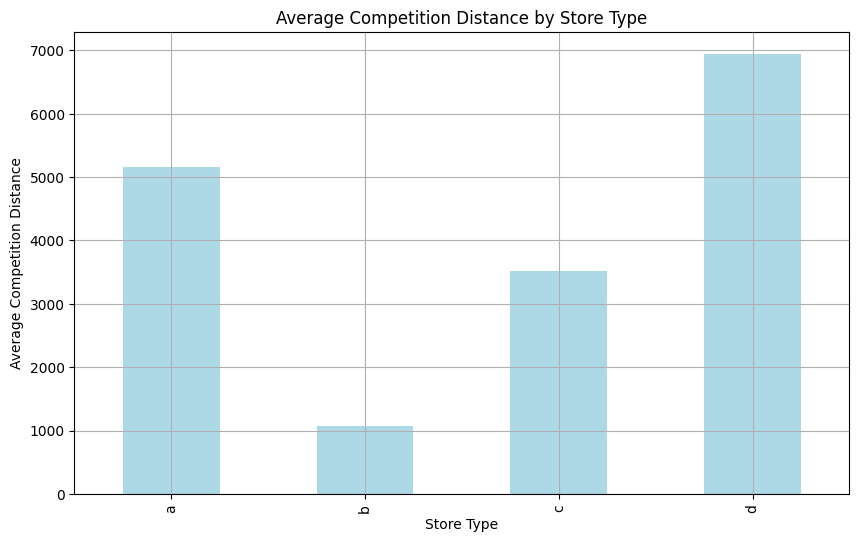

In [98]:
avg_competition_distance = Merged_Trian_df.groupby('store_type')['competition_distance'].mean()

plt.figure(figsize=(10, 6))
avg_competition_distance.plot(kind='bar', color='lightblue')
plt.title('Average Competition Distance by Store Type')
plt.xlabel('Store Type')
plt.ylabel('Average Competition Distance')
plt.grid()
plt.show()


# # 20. Which month sees the highest sales, and how does this change year over year?


<Figure size 1200x700 with 0 Axes>

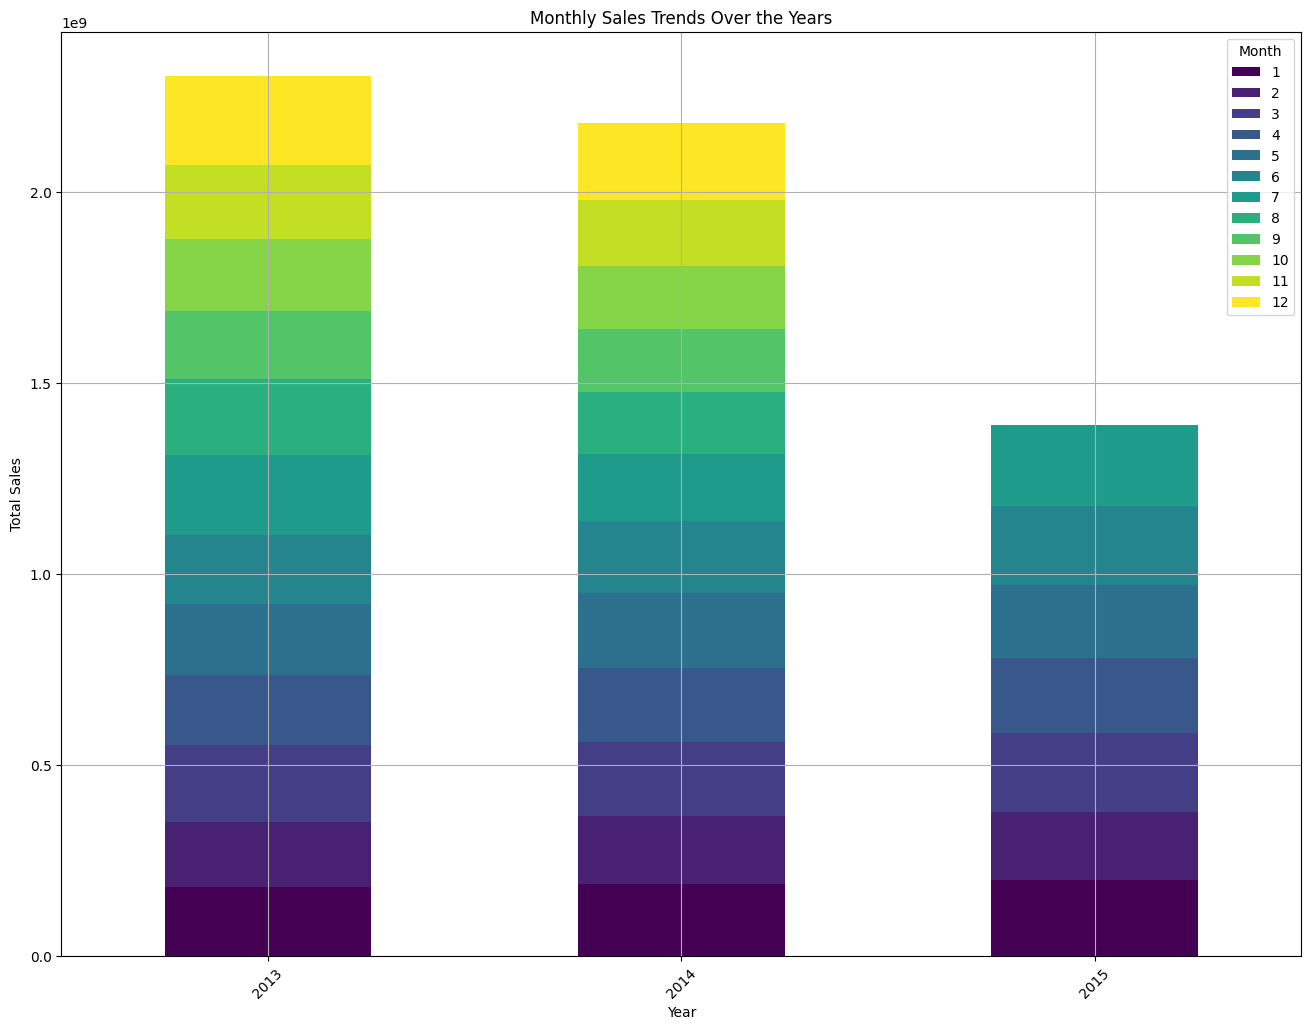

In [99]:
monthly_sales = Merged_Trian_df.groupby(['Year', 'Month'])['sales'].sum().unstack()

plt.figure(figsize=(12, 7))
monthly_sales.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Monthly Sales Trends Over the Years')
plt.xlabel('Year')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.legend(title='Month')
plt.grid()
plt.show()


# # 21. How does sales performance differ on weekends vs. weekdays?


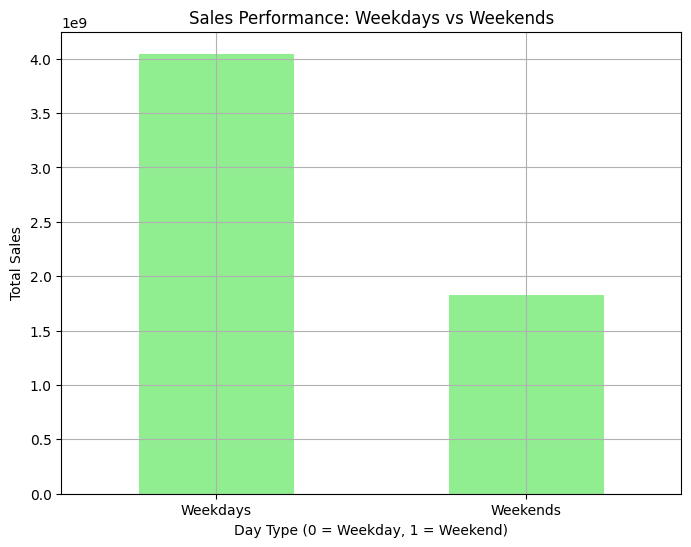

In [100]:
Merged_Trian_df['is_week_end'] = Merged_Trian_df['day_of_week'].apply(lambda x: 1 if x in [5, 6] else 0)
weekend_sales = Merged_Trian_df.groupby('is_week_end')['sales'].sum()

plt.figure(figsize=(8, 6))
weekend_sales.plot(kind='bar', color='lightgreen')
plt.title('Sales Performance: Weekdays vs Weekends')
plt.xlabel('Day Type (0 = Weekday, 1 = Weekend)')
plt.ylabel('Total Sales')
plt.xticks(ticks=[0, 1], labels=['Weekdays', 'Weekends'], rotation=0)
plt.grid()
plt.show()

# # 22. What is the trend in customer counts over the years?


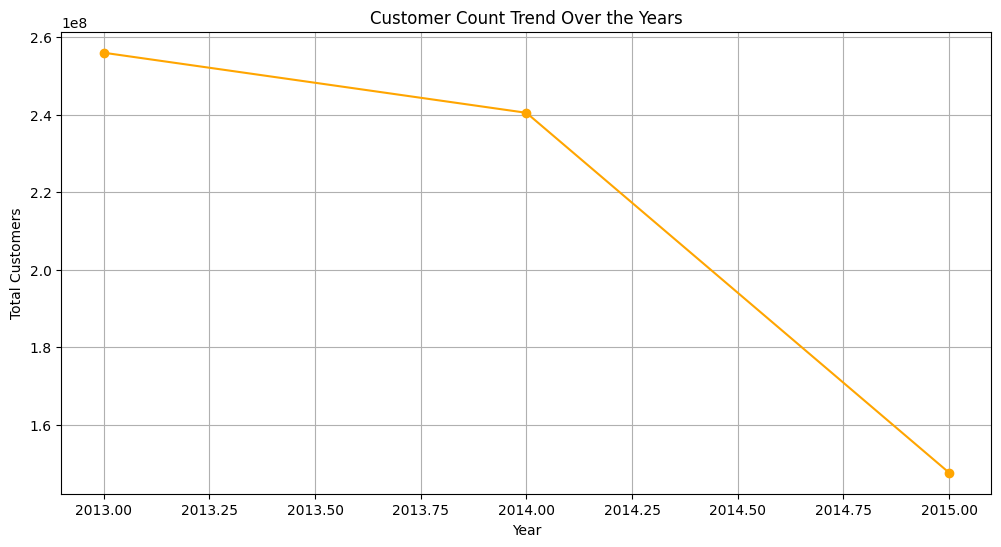

In [101]:
customer_trend = Merged_Trian_df.groupby('Year')['customers'].sum()

plt.figure(figsize=(12, 6))
customer_trend.plot(kind='line', marker='o', color='orange')
plt.title('Customer Count Trend Over the Years')
plt.xlabel('Year')
plt.ylabel('Total Customers')
plt.grid()
plt.show()

# %% [markdown]

# # 23. Which day of the week generates the highest sales?


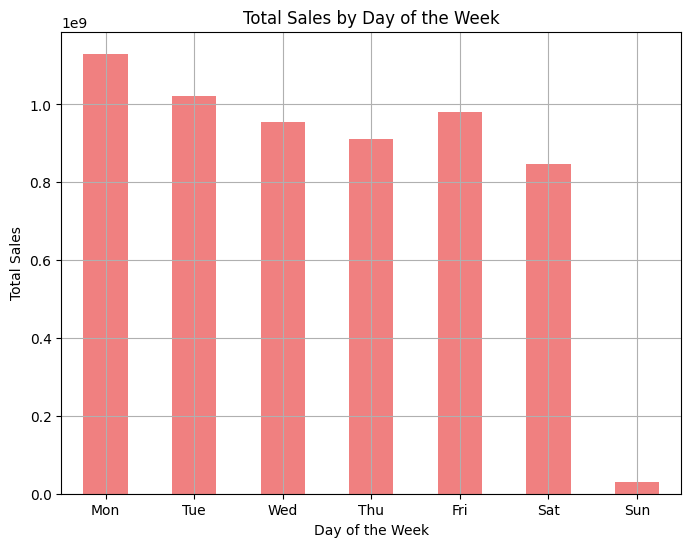

In [102]:
daily_sales = Merged_Trian_df.groupby('day_of_week')['sales'].sum()

plt.figure(figsize=(8, 6))
daily_sales.plot(kind='bar', color='lightcoral')
plt.title('Total Sales by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Total Sales')
plt.xticks(ticks=range(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], rotation=0)
plt.grid()
plt.show()

# # 24. How does the combination of promotions affect total sales?


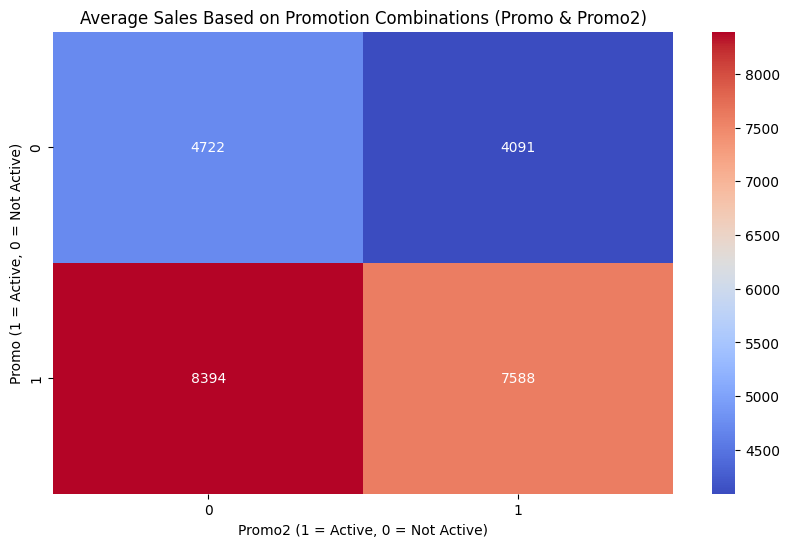

In [103]:
promo_sales = Merged_Trian_df.groupby(['promo', 'promo2'])['sales'].mean().unstack()

plt.figure(figsize=(10, 6))
sns.heatmap(promo_sales, annot=True, cmap='coolwarm', fmt='.0f')
plt.title('Average Sales Based on Promotion Combinations (Promo & Promo2)')
plt.xlabel('Promo2 (1 = Active, 0 = Not Active)')
plt.ylabel('Promo (1 = Active, 0 = Not Active)')
plt.show()


# # 25. Is there a noticeable trend in customer behavior leading up to major promotions?


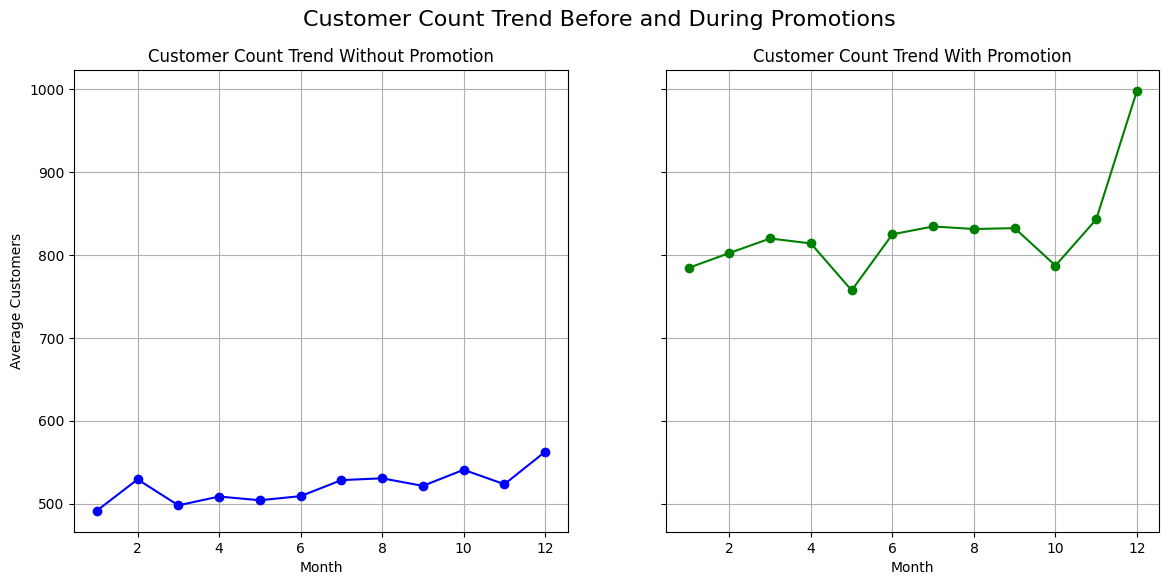

In [104]:
promo_sales_trend = Merged_Trian_df.groupby(['promo', 'Month'])['customers'].mean().unstack()

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

promo_sales_trend.loc[0].plot(kind='line', marker='o', ax=axes[0], color='blue')
axes[0].set_title('Customer Count Trend Without Promotion')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Average Customers')
axes[0].grid()

promo_sales_trend.loc[1].plot(kind='line', marker='o', ax=axes[1], color='green')
axes[1].set_title('Customer Count Trend With Promotion')
axes[1].set_xlabel('Month')
axes[1].grid()

fig.suptitle('Customer Count Trend Before and During Promotions', fontsize=16)
plt.show()